### Kmean to find which points train together

In [1]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload


%aimport src.utils.tardisml_utils

In [2]:
import os
import yaml
import pickle as pkl
import netCDF4 as nc4

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

fram detected
fram detected
fram detected
fram detected


In [3]:
# Load configuration

# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_demo.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template), Loader=yaml.FullLoader)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

In [4]:
# Get data and compute pcas, eofs
### NB : if file can't be found, it may be because you don't have the data in your folder on nird. All needed data is available in rootdir/Calliope

# Chronology
# (the same for all forcing fields, just take the first one)
df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'mslprs.pkl'))
chrono = df[df.time%1==timeofday].date

# Load landmask
mskok1d, mskok = load_data.get_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)

# Loading error of Target var PCA SIT assimilation - no assimilation
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)

# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xe, mu_e, RMSE_e = load_data.load_nc(filename, target_field)

# Reconstruction from PCA
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITerr.pkl")
pca_e = load_data.load_pca(filename)
PCs_e = feature_pca.pca_to_PC(pca_e, Xe, mskok1d)
EOF1d_e, EOF2d_e = feature_pca.compute_eof(n_components, Xe, pca_e, mskok)
Xe_rec = xr.dot(EOF2d_e,PCs_e) + mu_e


# Load forecast values
data_dir = nosit_dir
list_files = feature_pca.missing_file(chrono, data_dir, template)
nc_f = xr.open_mfdataset(list_files, combine='nested', concat_dim='rdim')

forcing_fields = ["airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d", "precip"]

#forcing_fields = ["airtmp", "dewpt", "mslprs", "nlwrad", "nswrad", "precip", "radflx", "shwflx", "vapmix", "wndewd", "wndnwd"]
#forcing_fields = [f + "_mean21d" for f in forcing_fields]

#Load forcing values
forcings = dict()
filepath = os.path.join(rootdir,forcing_bdir)
for field in forcing_fields:
    forcings[field] = np.load(f'{filepath}/{field}.npy')
Nf = len(forcing_fields) # Number of forcing fields

Load PCA: /nird/projects/nird/NS2993K/Calliope/results/pca_i200-600_j600-881/pca_hice00_8N_SITerr.pkl



## Compute the area

In [26]:
from sklearn.cluster import KMeans

In [27]:
# [[.] [.]] shape(2, 1)
# colle comme ca : [....]...[....]
# donc colle j1 j2 j3 ...

In [28]:
def get_area(data, lim_idm, lim_jdm, index_mask, keep=[]):
    """ Keep only data for the given geographical zone
    In:
        data        : dict or xarray.core.dataset.Dataset -- Data to process
        lim_idm     : tuple                               -- limits of the geographical area to be preserved (following axes x)
        lim_jdm     : tuple                               -- limits of the geographical area to be preserved (following axes y)
        index_mask  : numpy.ndarray                       -- mask to apply for nonan if needed (ex: for forcings nonan to keep)
        keep        : String list                         -- Parameters values to keep in data
        
    Out:
        X_sel       : dict -- key = field name, value = (y, x) array, data array restricted to the given geographical area and mean over time, reversed data if rev
        X_sel_nonan : dict -- same than Xm_sel without NaN values
    """
    
    X_sel = dict()
    X_sel_nonan = dict()
    
    t = data[keep[0]].shape[0]
    n = index_mask.shape[1]
    
    for field in keep:
            X_sel[field] = data[field].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm)).values
            X_sel_nonan[field] = X_sel[field][np.isfinite(X_sel[field])]
            X_sel_nonan[field] = np.reshape(X_sel_nonan[field], [t, n])

    return X_sel, X_sel_nonan


def keep_nonan(data, index_mask, keep=[]):
    """ Keep only masked values (index_mask), corresponding to the land where SIT data is available (nonNaN)
    """
    X_sel_nonan = dict()
    
    t = 1461
    n = index_mask.shape[1]
    
    for f in keep:
        X_sel_nonan[f] = np.array([data[f][time, index_mask[0], index_mask[1]] for time in range(t)])

    return X_sel_nonan

In [29]:
# Covariables and forcings to evaluate
keep_cov=["hice00", "hsnw00", "ssh00", "fice00"] 
keep_fg=["airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d", "precip"]

nb_vars = len(keep_cov) + len(keep_fg)

#can add shortwave flux : swflx00 : cov ou fg ?

In [30]:
# get index of non NaN values
nc1 = xr.open_dataset(os.path.join(rootdir, withsit_dir, 'TP4DAILY_2014_000.nc'))
sel = np.squeeze(nc1["hice00"].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm)).values)
index_mask = np.argwhere(~np.isnan(sel)).T

In [31]:
# Select to datas
X_sel_cov_wnan, X_sel_cov = get_area(nc_f, lim_idm, lim_jdm, index_mask, keep=keep_cov)
X_sel_fg = keep_nonan(forcings, index_mask, keep=keep_fg)

In [32]:
def data_array(covs_sel_nonan, fgs_sel_nonan, Xe):
    """ Compute the correlation between the error and the various parameters
        In:
            covs_sel_nonan : -- Covariable time serie for the wanted point and without NaN values
            fgs_sel_nonan  : -- Forcings time serie for the wanted point and without NaN values
            Xe             : -- Error time serie, shape (t, y, x) 
        Out:
            matrix  : -- Computed correlation between error and parameter on each point. Lines = points, columns = data variables
            err_cst : -- index of the NaN values due to the correlation computation
    """
    t = Xe.shape[0]
    n = covs_sel_nonan["hice00"].shape[1]
    nb_vars = len(covs_sel_nonan.keys()) + len(fgs_sel_nonan.keys())
    matrix = np.empty([n, nb_vars])
    
    # Keep no NaN
    Xe_nonan = np.reshape(np.array(Xe)[np.isfinite(np.array(np.array(Xe)))], [t, n])
    err_cst = []
    
    for pt in range(n):
        true_pt = Xe_nonan[:, pt]
        if np.isnan(true_pt).any() or not np.any(true_pt):
            matrix[pt] = np.array([np.nan for f in range(nb_vars)])
            err_cst.append(pt)
    
    # Compute correlations for each data
    for ind_f, f in enumerate(keep_cov):
        for pt in range(n):
            if pt not in err_cst:
                matrix[pt, ind_f] = np.corrcoef(covs_sel_nonan[f][:, pt], Xe_nonan[:, pt])[0, 1]
        
    for ind_f, f in enumerate(keep_fg):
        for pt in range(n):
            if pt not in err_cst:
                matrix[pt, ind_f+len(keep_cov)] = np.corrcoef(fgs_sel_nonan[f][:, pt], Xe_nonan[:, pt])[0, 1]
        
    return matrix, err_cst

In [ ]:
corr, ind_err = data_array(X_sel_cov, X_sel_fg, Xe)

In [34]:
# Remove NaN values due to correlation computation (constant error etc)
nan_mask = np.isfinite(np.array(corr[:, 1]))
corr_nonan = np.empty([np.count_nonzero(nan_mask), nb_vars])
for i in range(nb_vars):
    corr_nonan[:, i] = corr[:, i][nan_mask]

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
kmeans.fit(corr_nonan)
y_kmeans = kmeans.predict(corr_nonan)

In [36]:
def get_fullmap(Y_km, shape, nan_mask):
    """ Get the fullmap with NaN values = -1 and no-NaN values = cluster's number in kmean classification
    """
    # Add NaN where can't compute correlation (nan_mask)
    Y_2 = np.empty(nan_mask.shape[0])
    sft = 0
    for e in range(Y_2.shape[0]):
        if not nan_mask[e]:
            Y_2[e] = -1
            sft += 1
        else:
            Y_2[e] = Y_km[e-sft]
    
    full_map = np.reshape(np.array([np.nan for i in range(shape[0]*shape[1])]), [shape[0], shape[1]])
    for ind, (i, j) in enumerate(zip(index_mask[0], index_mask[1])):
        full_map[i, j] = Y_2[ind]
        ind += 1
        
    return xr.DataArray(full_map, dims=['jdim', 'idim'])

def plot_map(Y_km, shape, nan_mask):
    get_fullmap(Y_km, shape, nan_mask).plot(vmin=-2, vmax=max(Y_km))

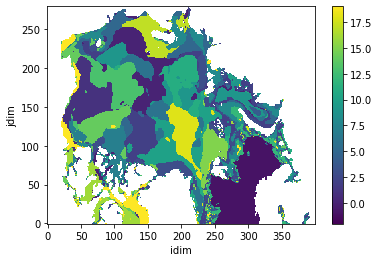

In [37]:
plot_map(y_kmeans, Xe.shape[1:], nan_mask)

In [15]:
kmeans2 = KMeans(n_clusters=40)
kmeans2.fit(corr_nonan)
y_kmeans2 = kmeans2.predict(corr_nonan)

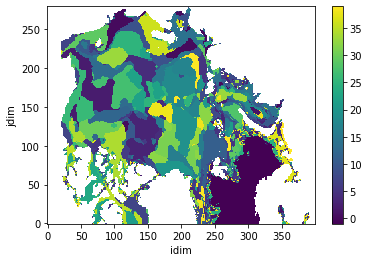

In [93]:
plot_map(y_kmeans2, Xe.shape[1:], nan_mask)

In [23]:
# Save the kmean result to work on the same
"""
with open(f'{rootdir}Calliope/areas/correlations.pickle', "wb") as f:
    pkl.dump(corr, f, protocol=pkl.HIGHEST_PROTOCOL)
with open(f'{rootdir}Calliope/areas/y_kmeans.pickle', "wb") as f:
    pkl.dump(y_kmeans2, f, protocol=pkl.HIGHEST_PROTOCOL)
"""

## Load the kmean computation 

In [9]:
with open(f'{rootdir}Calliope/areas/y_kmeans.pickle', "rb") as f:
    y_kmeans2 = pkl.load(f)
    
with open(f'{rootdir}Calliope/areas/correlations.pickle', "rb") as f:
    corr = pkl.load(f)

In [10]:
# Remove NaN values due to correlation computation (constant error etc)
nan_mask = np.isfinite(np.array(corr[:, 1]))
corr_nonan = np.empty([np.count_nonzero(nan_mask), nb_vars])
for i in range(nb_vars):
    corr_nonan[:, i] = corr[:, i][nan_mask]

## Observe the clusters

In [13]:
n_clusters = max(y_kmeans2) + 1
fullmap = get_fullmap(y_kmeans2, Xe.shape[1:], nan_mask)

In [17]:
# Chosen set
def plot_1cluster(n, Y_km, shape, nan_mask):
    """ Plot a given cluster [0-max] on a map
    """
    fullmap = get_fullmap(Y_km, shape, nan_mask)
    
    fullmap.where(fullmap >= -1).plot(vmin=-2, vmax=-2, cmap=plt.cm.Blues, add_colorbar=False)
    fullmap.where(fullmap == n).plot(add_colorbar=False, cmap=plt.cm.Reds)
    plt.title(f'Cluster {n}')
    nb_pts = np.count_nonzero(np.array(fullmap) == n)
    print(f'Number of point in cluster {n} : {nb_pts}')

Number of point in cluster 0 : 2480


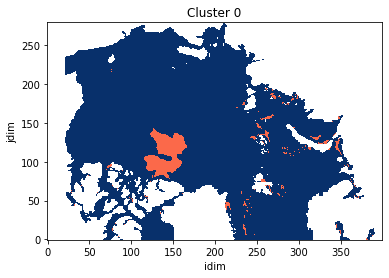

Number of point in cluster 1 : 1406


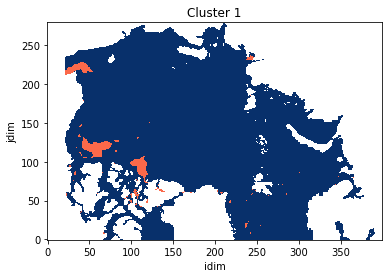

Number of point in cluster 2 : 1338


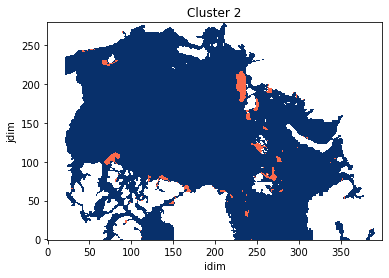

Number of point in cluster 3 : 1045


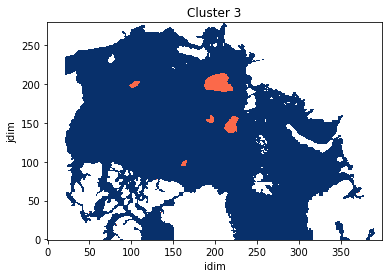

Number of point in cluster 4 : 1403


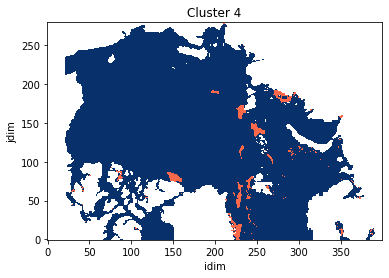

Number of point in cluster 5 : 1660


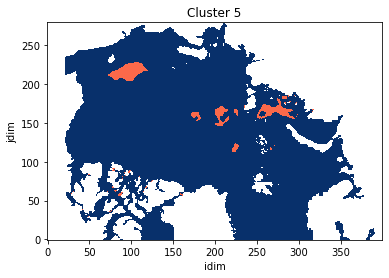

Number of point in cluster 6 : 2269


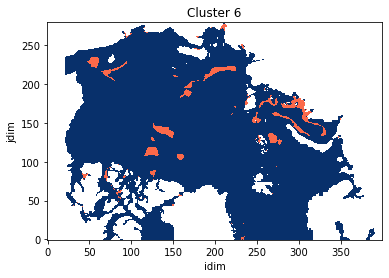

Number of point in cluster 7 : 2264


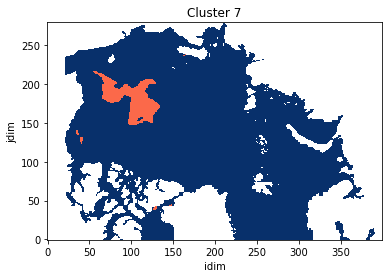

Number of point in cluster 8 : 906


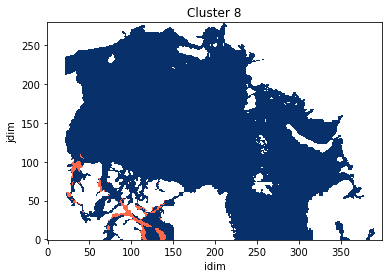

Number of point in cluster 9 : 463


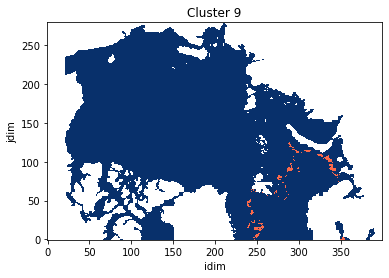

Number of point in cluster 10 : 2155


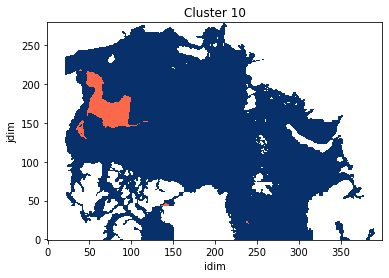

Number of point in cluster 11 : 1237


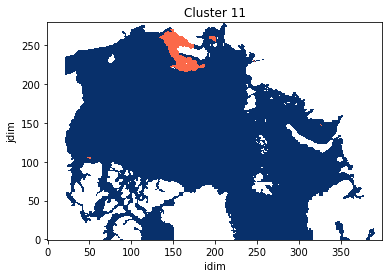

Number of point in cluster 12 : 1424


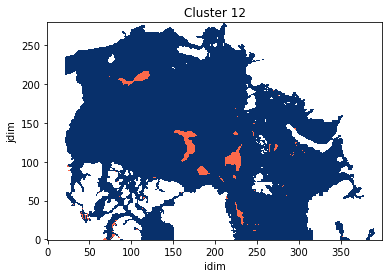

Number of point in cluster 13 : 1567


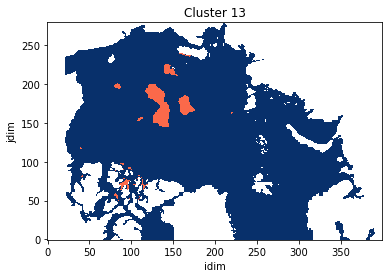

Number of point in cluster 14 : 603


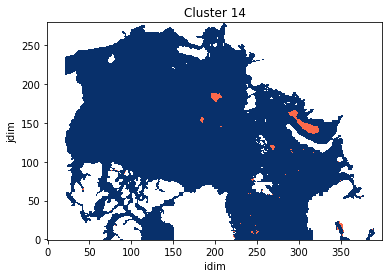

Number of point in cluster 15 : 810


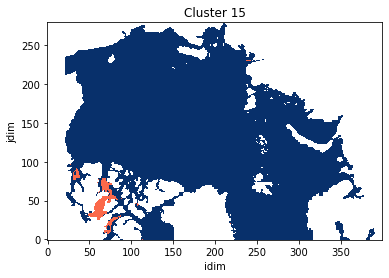

Number of point in cluster 16 : 2081


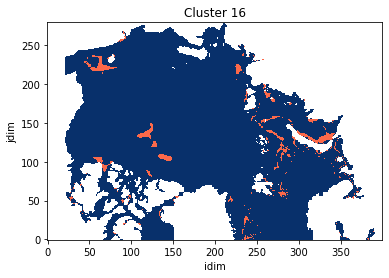

Number of point in cluster 17 : 1561


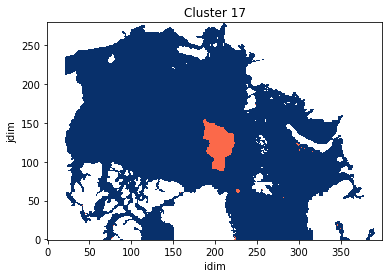

Number of point in cluster 18 : 1071


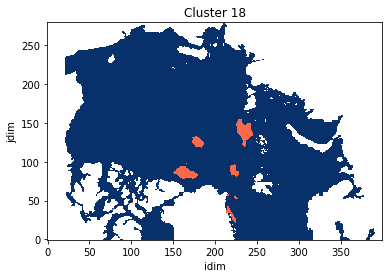

Number of point in cluster 19 : 786


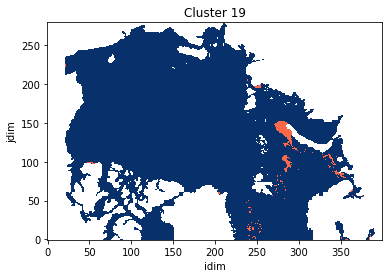

Number of point in cluster 20 : 1569


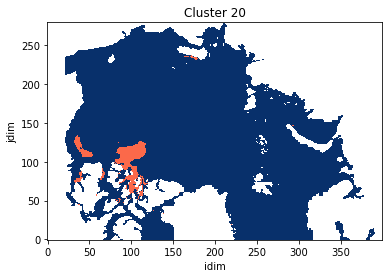

Number of point in cluster 21 : 1802


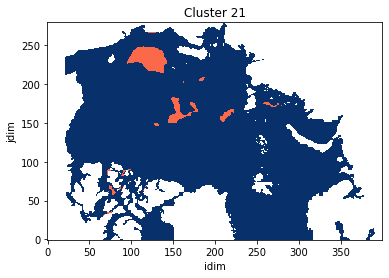

Number of point in cluster 22 : 1877


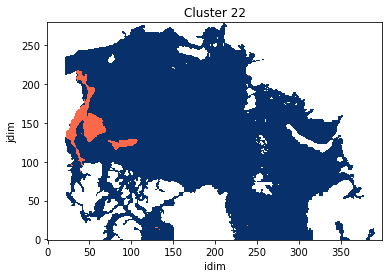

Number of point in cluster 23 : 1241


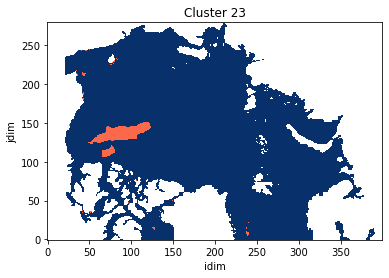

Number of point in cluster 24 : 1343


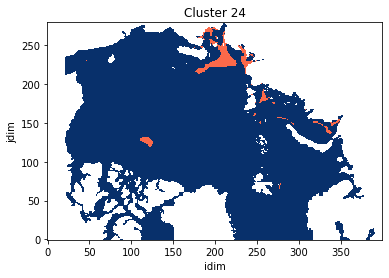

Number of point in cluster 25 : 1799


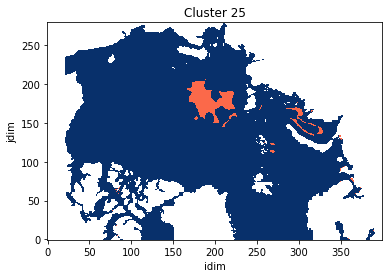

Number of point in cluster 26 : 981


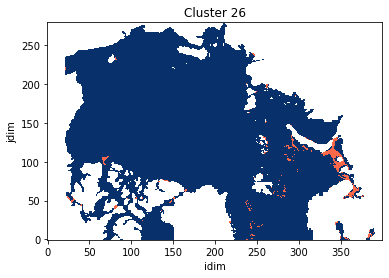

Number of point in cluster 27 : 1454


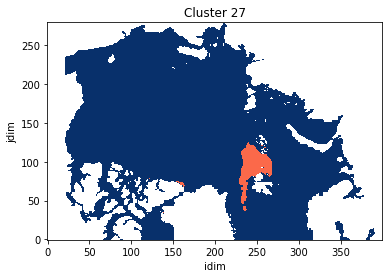

Number of point in cluster 28 : 238


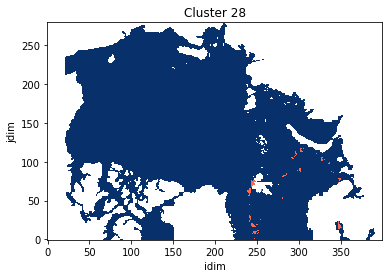

Number of point in cluster 29 : 1075


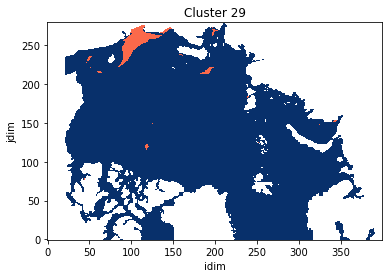

Number of point in cluster 30 : 1132


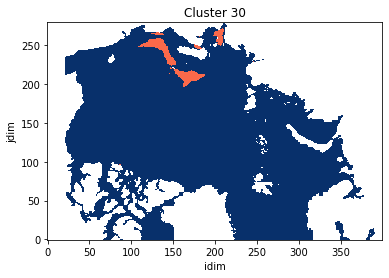

Number of point in cluster 31 : 1215


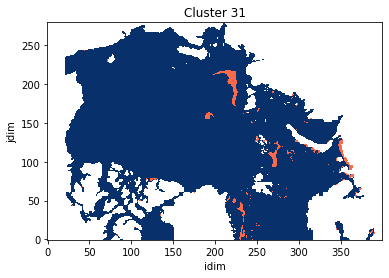

Number of point in cluster 32 : 1365


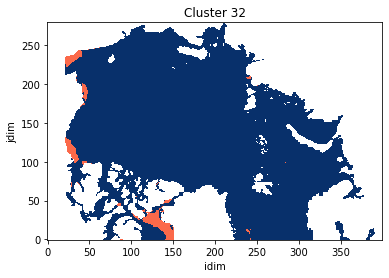

Number of point in cluster 33 : 1418


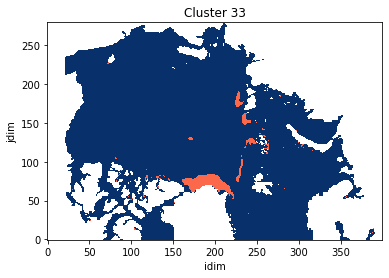

Number of point in cluster 34 : 1485


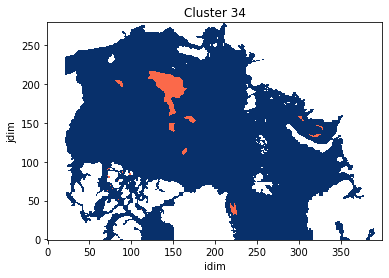

Number of point in cluster 35 : 1747


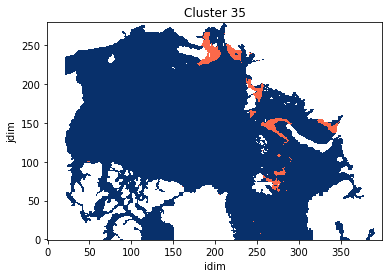

Number of point in cluster 36 : 1325


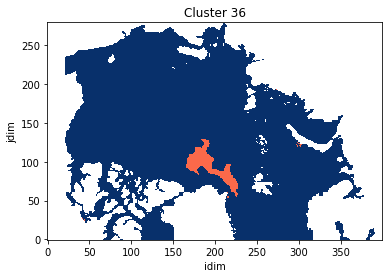

Number of point in cluster 37 : 867


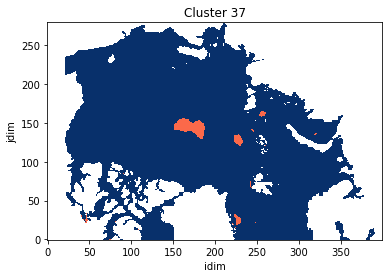

Number of point in cluster 38 : 1436


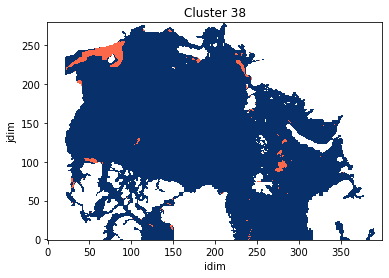

Number of point in cluster 39 : 415


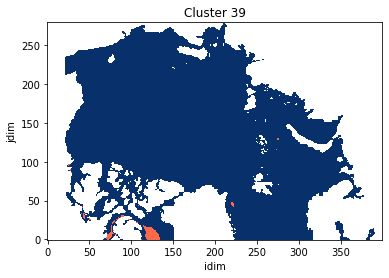

In [22]:
for i in range(40):
    plot_1cluster(i, y_kmeans2, Xe.shape[1:], nan_mask)
    plt.show()

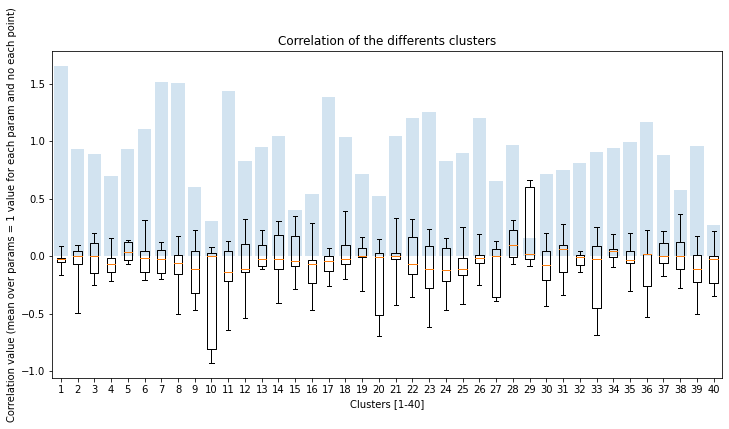

In [21]:
# Chosen set
def plot_stats_all_clusters(y_kmeans, corr, fullmap, n_clusters):
    """ Plot each cluster stats + cluster sizes in background
    """
    # Input : (cluster, correlations)
    n_param = corr.shape[1]
    cors_clust = [None for i in range(n_clusters)]
    cor_mean = np.empty([n_param, n_clusters])
    for c in range(n_clusters):
        cors_clust[c] = corr[np.where(y_kmeans == c)]
        cor_mean[:, c] = np.mean(cors_clust[c], axis=0)

    # Cluster sizes
    sizes = np.empty(n_clusters)
    for cluster in range(n_clusters):
        sizes[cluster] = np.count_nonzero(np.array(fullmap) == cluster) / 1500
        
    
    # Plots
    fig, ax = plt.subplots(figsize=(int(0.3*n_clusters),6))
    
    plt.bar(x=np.arange(1, n_clusters+1), height=sizes, alpha=0.2)
    
    plt.boxplot(cor_mean, whis=[0, 100])
    plt.xlabel('Clusters [1-40]')
    plt.ylabel('Correlation value (mean over params = 1 value for each param and no each point)')
    plt.title(f'Correlation of the differents clusters')
    

plot_stats_all_clusters(y_kmeans2, corr_nonan, fullmap, n_clusters)

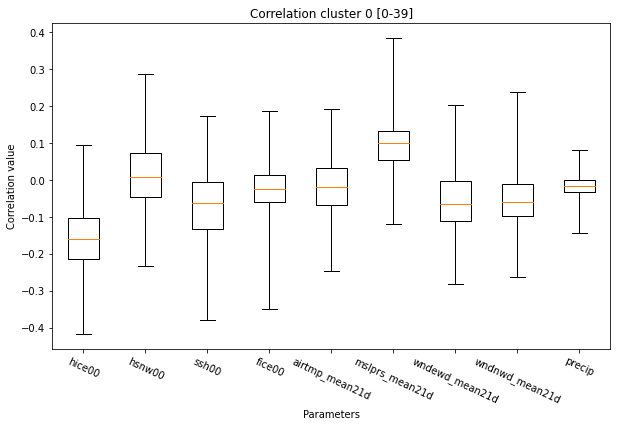

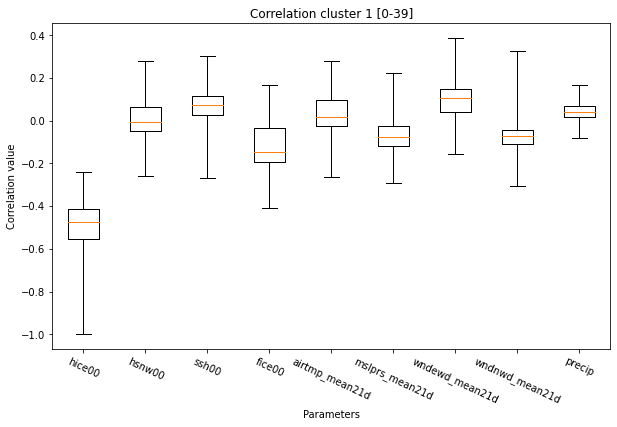

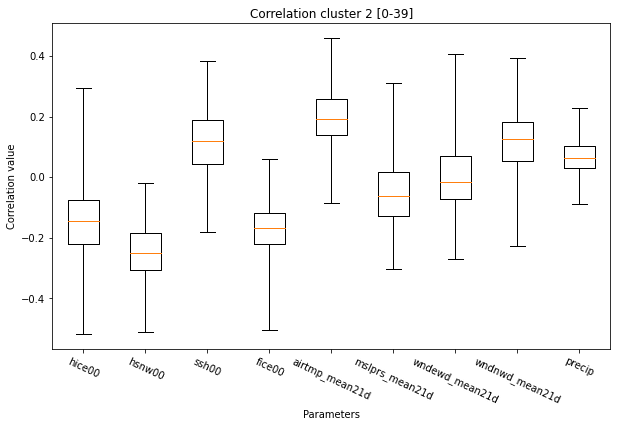

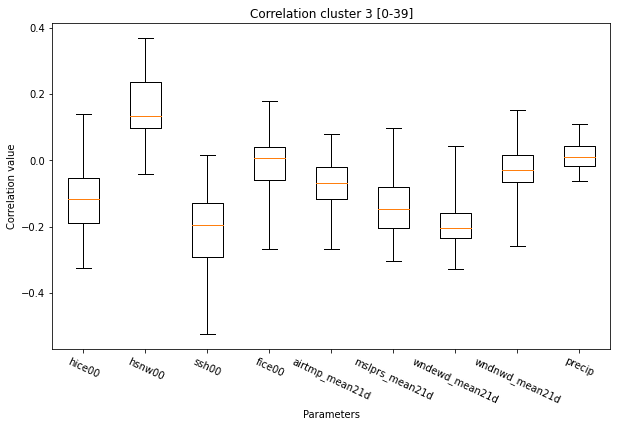

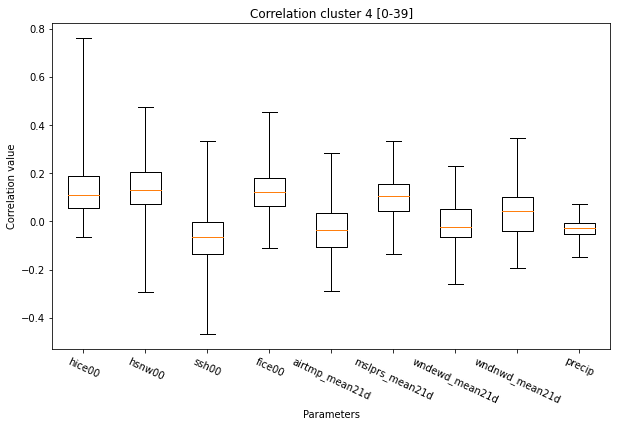

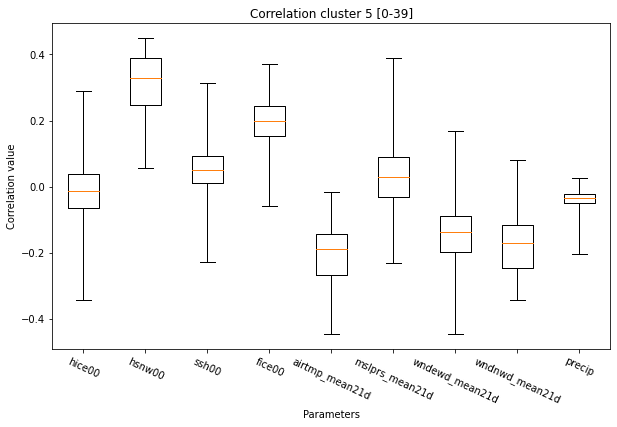

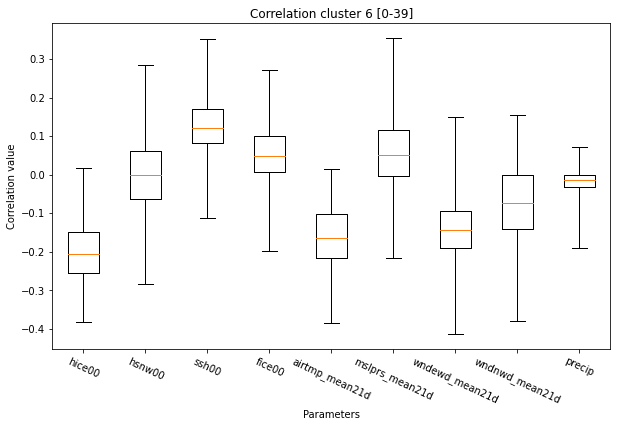

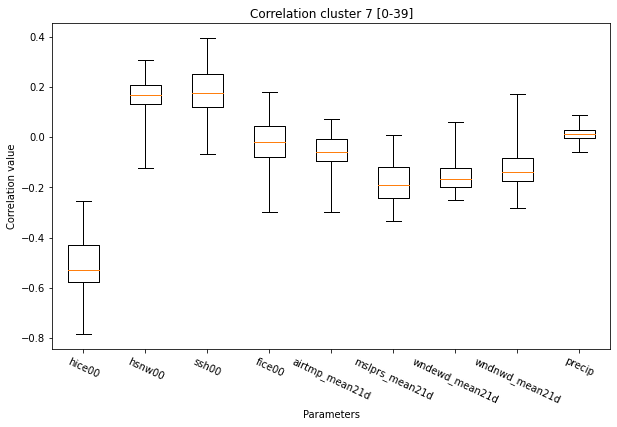

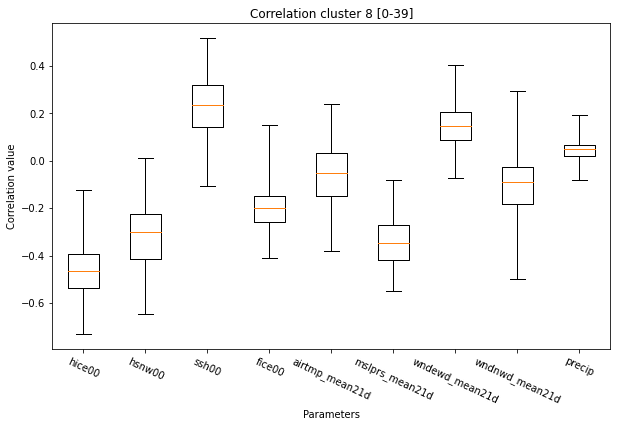

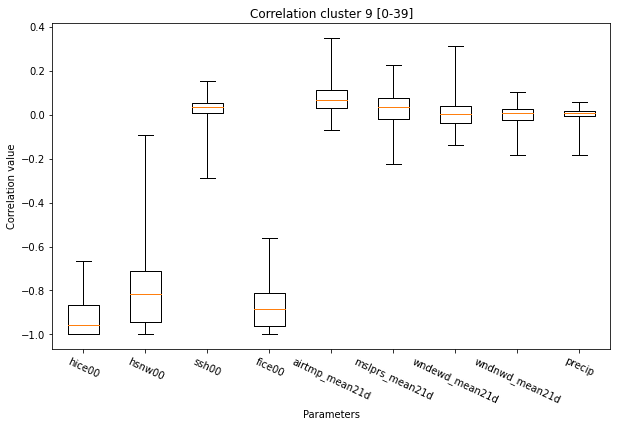

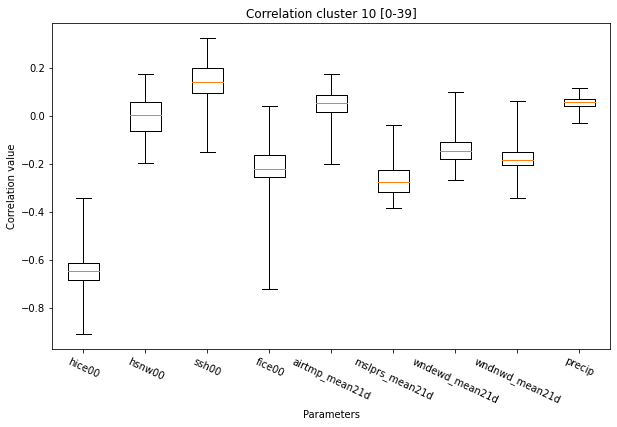

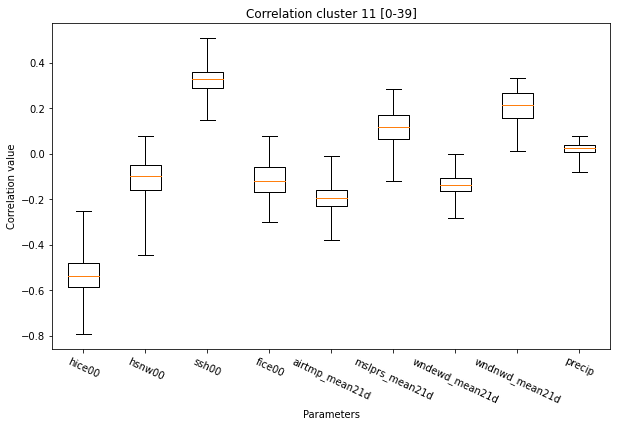

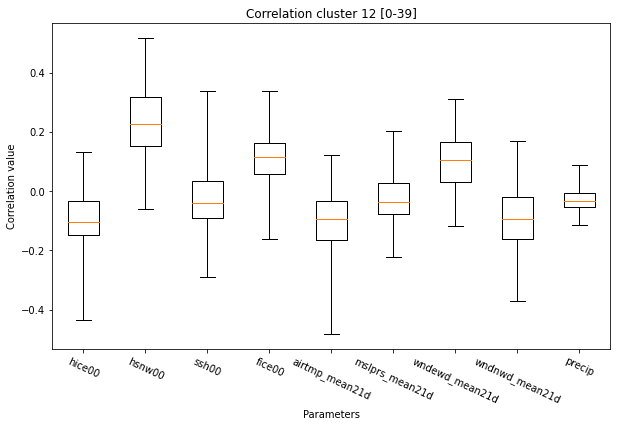

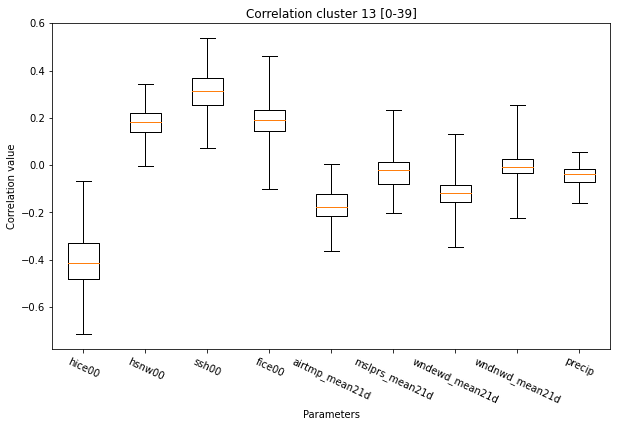

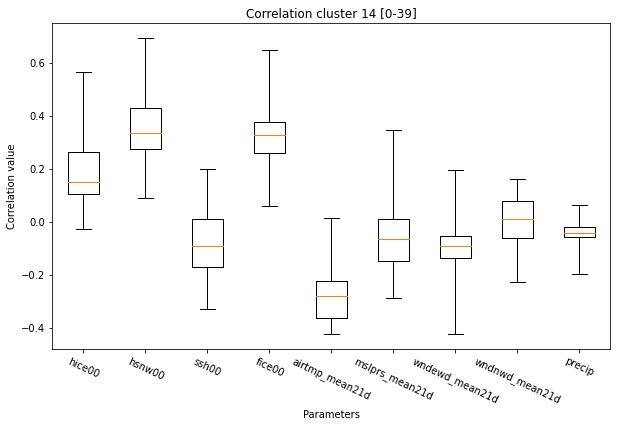

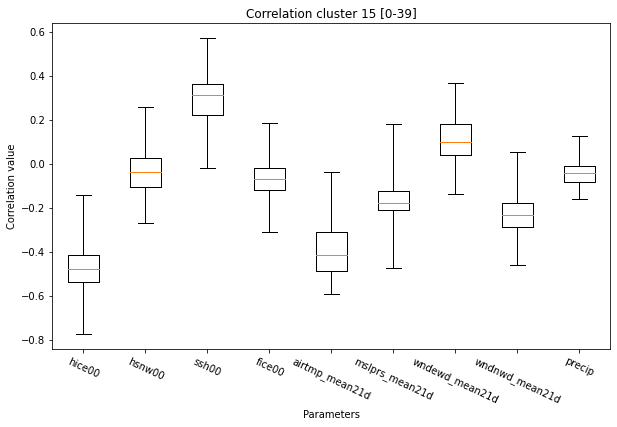

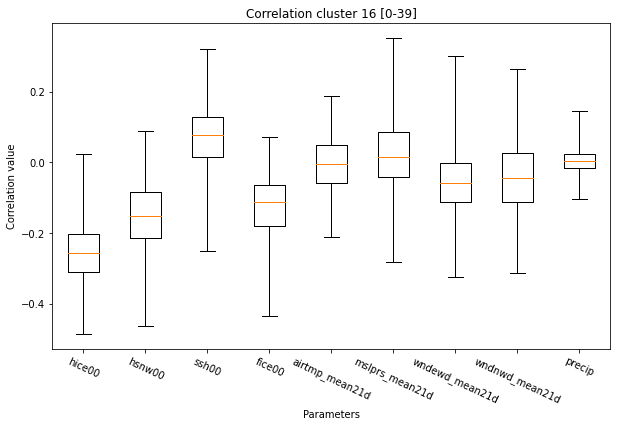

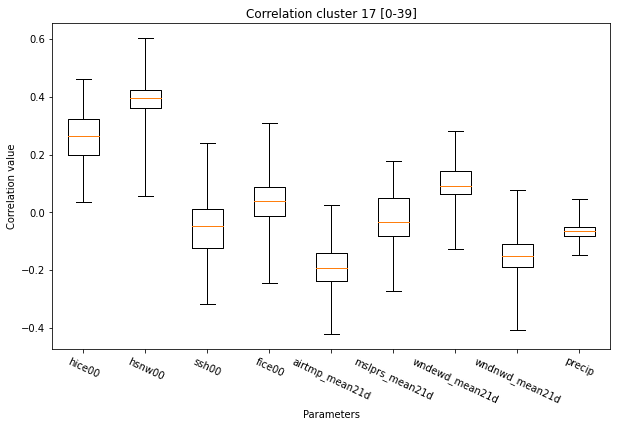

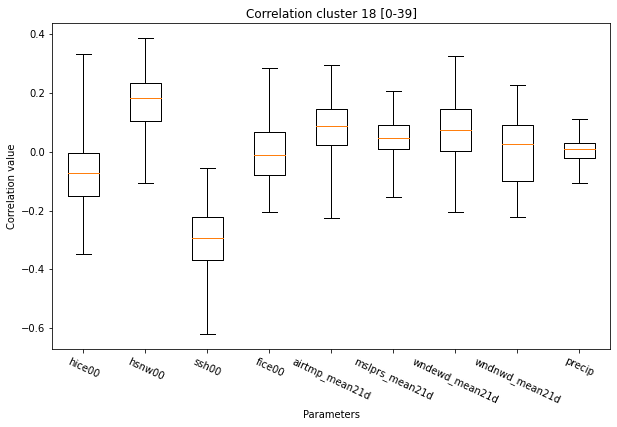

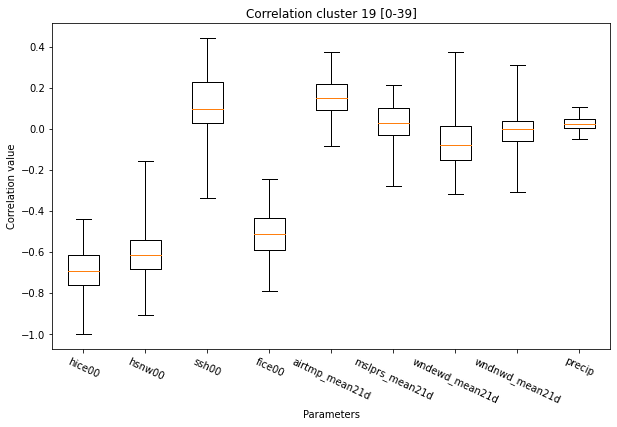

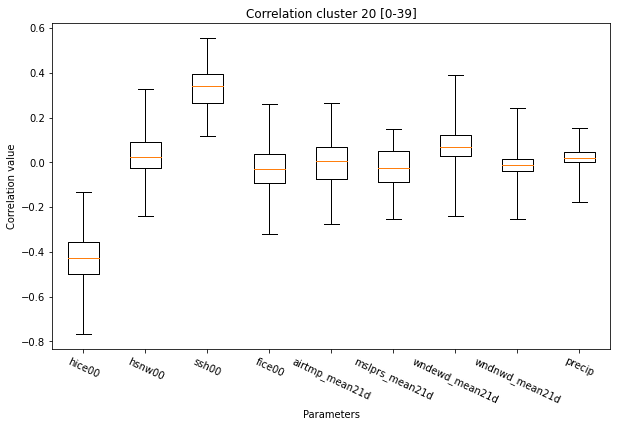

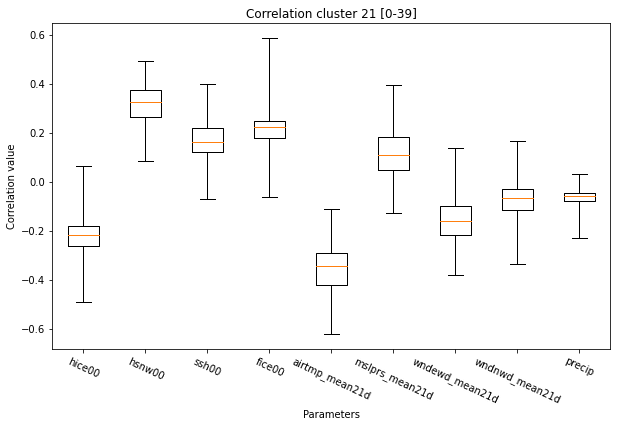

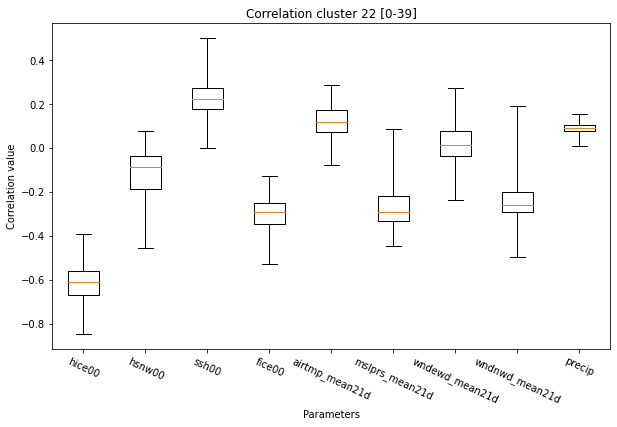

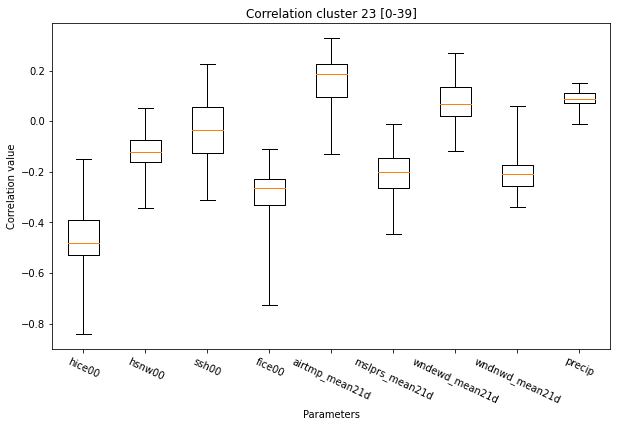

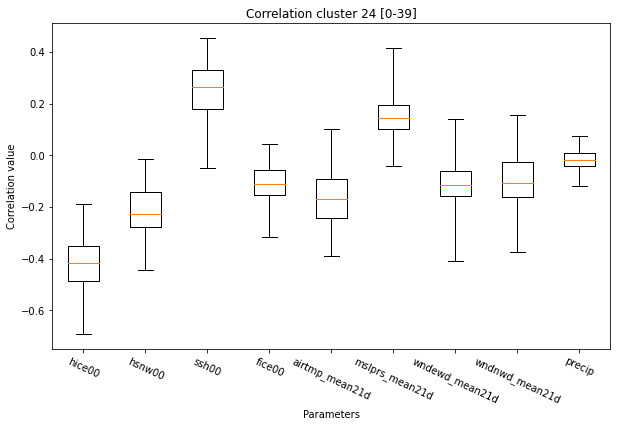

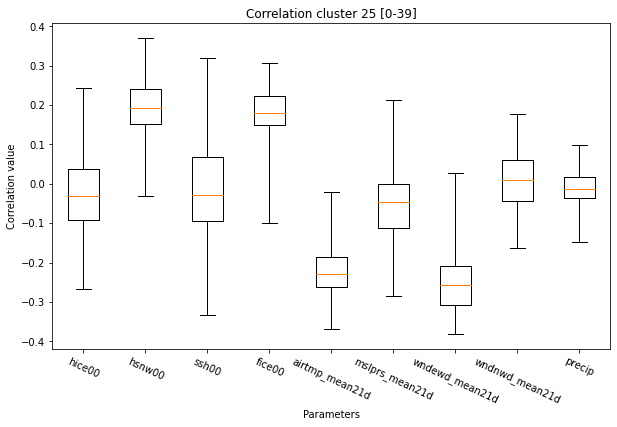

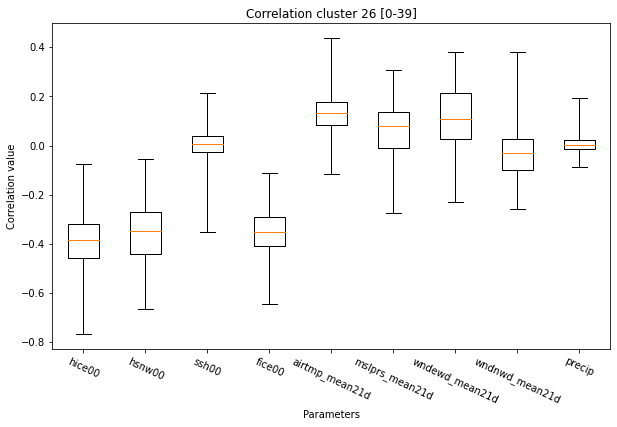

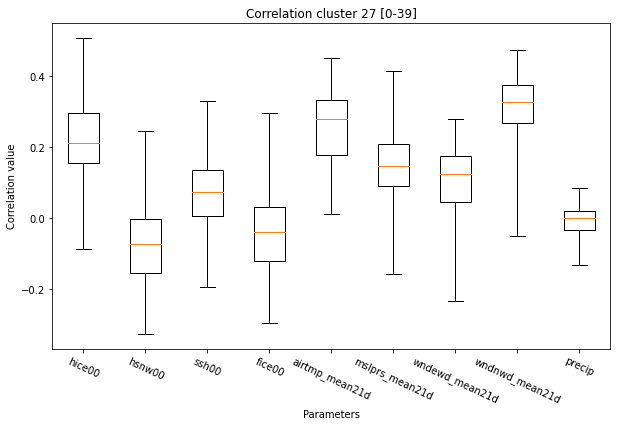

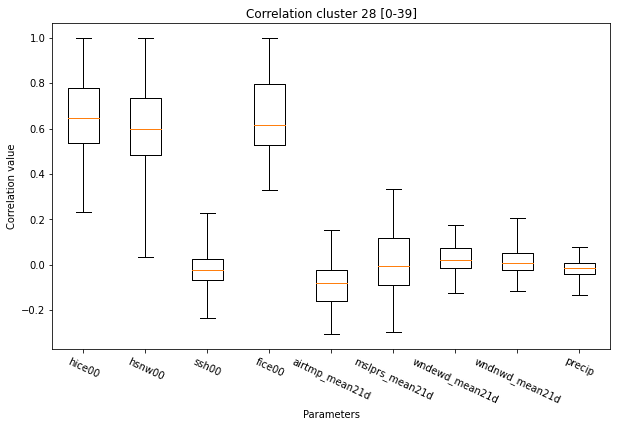

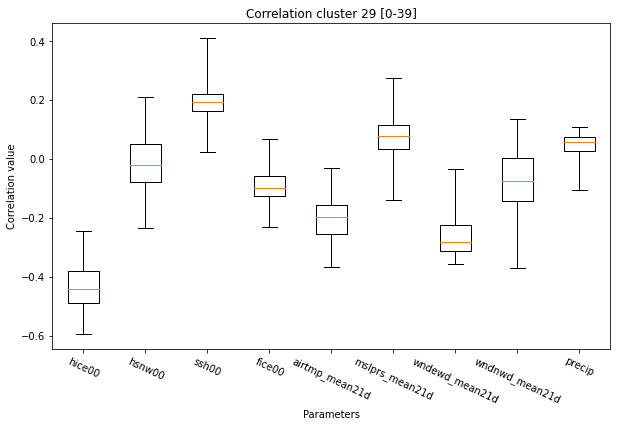

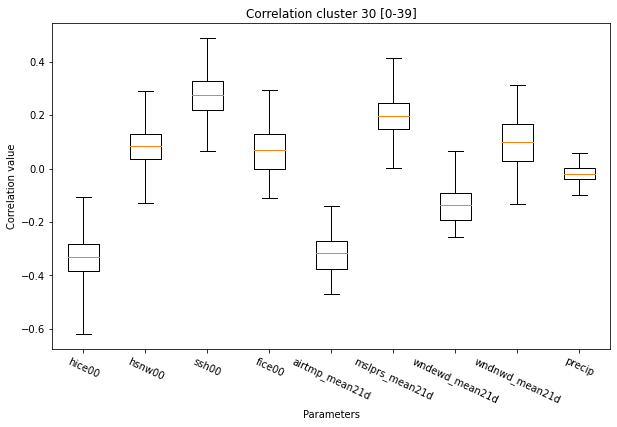

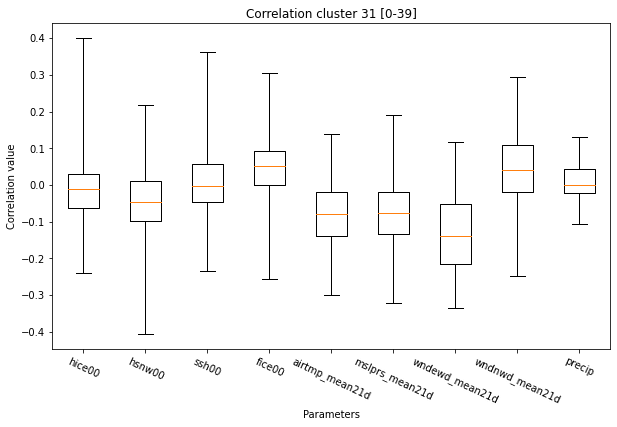

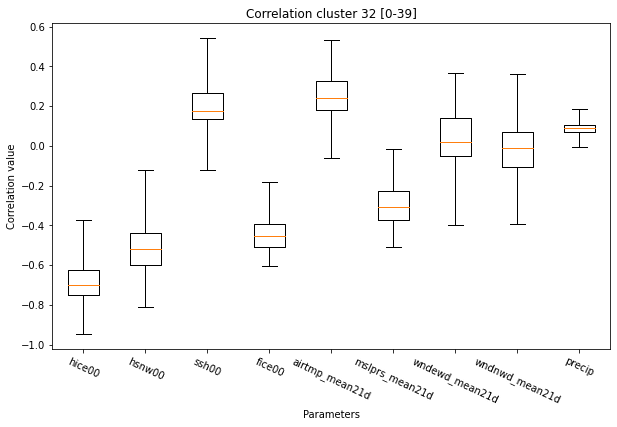

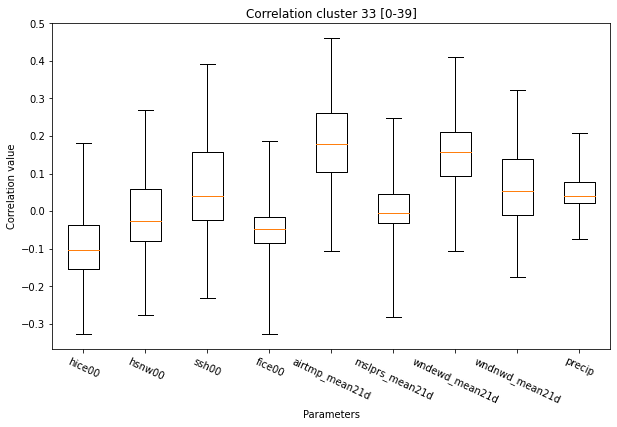

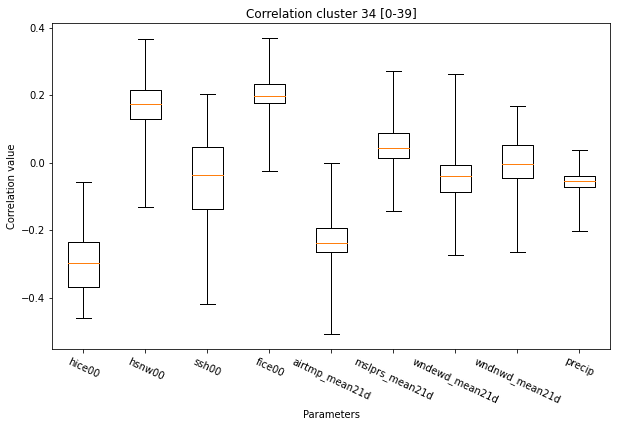

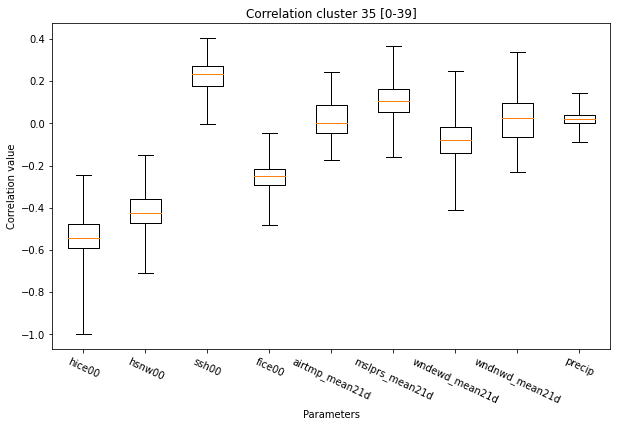

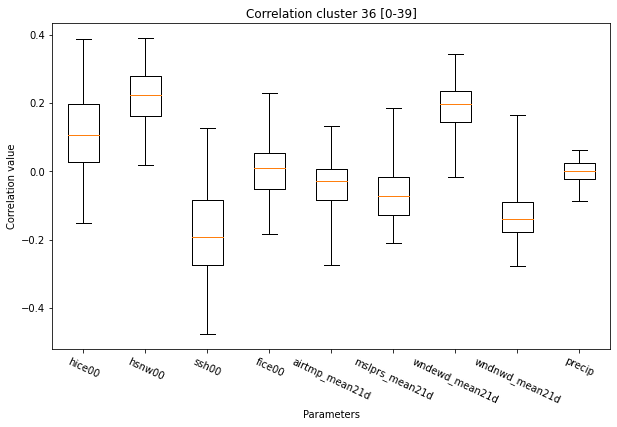

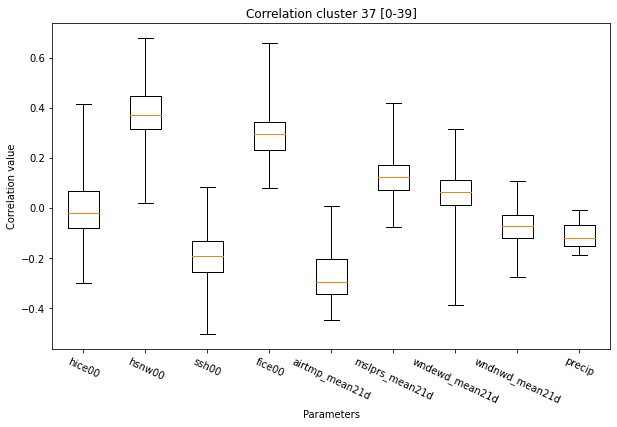

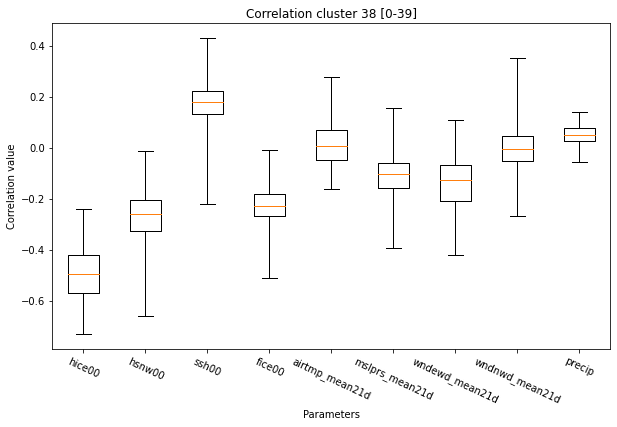

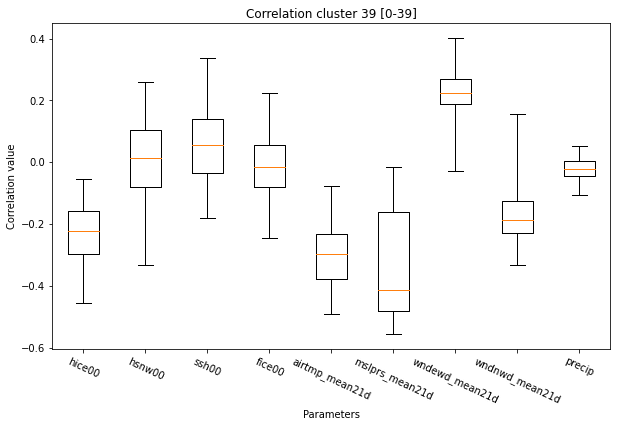

In [15]:
# Chosen set
def plot_stats_1_cluster(y_kmeans, corr, cluster, params):
    """ Plot the stats for 1 cluster
    """
    cor_mean = corr[np.where(y_kmeans == cluster)]

    # Plots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.boxplot(cor_mean, whis=[0, 100])
    plt.xticks(range(1, len(params)+1), params, rotation= -25)
    plt.xlabel('Parameters')
    plt.ylabel('Correlation value')
    plt.title(f'Correlation cluster {cluster} [0-39]')
    
for c in range(n_clusters):
    plot_stats_1_cluster(y_kmeans2, corr_nonan, c, keep_cov+keep_fg)
    plt.show()

## Build the dataset

In [14]:
# Chosen cluster infos
cluster = 10
pts = fullmap.where(fullmap == cluster)
index_cluster = np.argwhere(~np.isnan(np.array(pts))).T

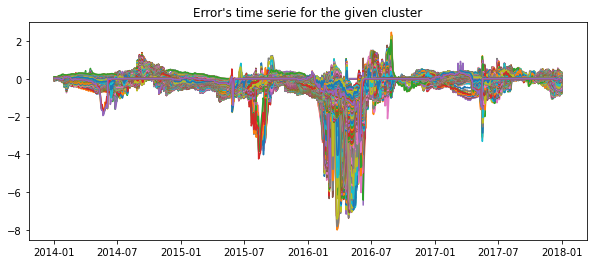

In [65]:
def plot_errors_ts(Xe, index_cluster):
    """ Plot all errors time series for all the point of a cluster
    """
    plt.figure(figsize=(10, 4))
    plt.title("Error's time serie for the given cluster")
    for (y, x) in zip(index_cluster[0], index_cluster[1]):
        plt.plot(chrono, Xe[:, y, x])

plot_errors_ts(Xe, index_cluster)

Number of point in cluster 10 : 2155


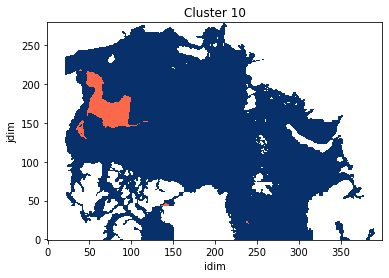

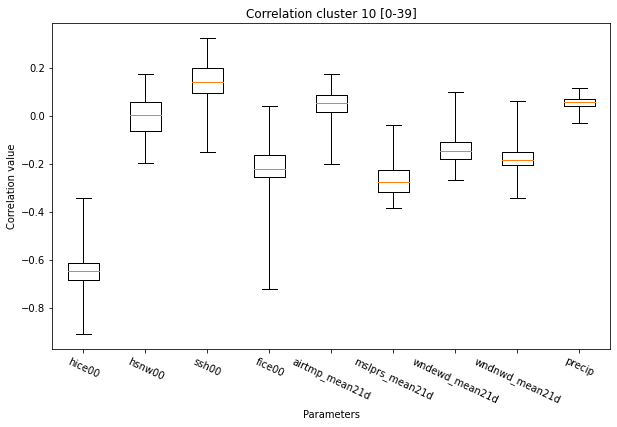

In [18]:
plot_1cluster(cluster, y_kmeans2, Xe.shape[1:], nan_mask)
plot_stats_1_cluster(y_kmeans2, corr_nonan, cluster, keep_cov+keep_fg)

In [15]:
def scale_data(train_data, test_data):
    max_val = train_data.max()
    min_val = train_data.min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, test_scaled

def build_dataset(Xe, cov, fgs, index_cluster, chrono, keep_cov=[], keep_fgs=[], train_p=3/4, val_p=0, times=[0]):
    """ Build a dataset
    In:
        Xe            : -- error time serie
        cov           : -- covariables time series
        fgs           : -- forcings time series
        index_cluster : -- index of all points belonging to the cluster
        chrono        : -- chrono over all the test-train period
        keep_cov      : String list -- name of the covariabesl to keep
        keep_fgs      : String list -- name of the forcings to keep
        train_p       : float       -- proportion of data to be kept in the train set
        val_p         : float       -- proportion of data to be kept in the val set (unused now)
        times         : int list    -- if != [0], timestep to keep for each input data (change output dataset shape)
                                    -- if == [0] for DNN network, else for LSTM network
    Out:
        dataset            : dict{"Xtest", "Xtrain", "ytest", "ytrain"}
                            -- Xtrain shape : (ntrain*nb_pts, nb_params) if times == [0]
                                            : (ntrain*nb_pts, len(times), nb_params) else
                            -- ytrain shape : (ntrain*nb_pts)
        (n, ntrain, ntest) : number of data for the various datasets
        rchrono            : time serie dor the final data (same than chrono if times==[0])
    """
    t = cov[keep_cov[0]].shape[0]
    nb_pts = index_cluster.shape[1]
    nb_params = len(keep_cov) + len(keep_fgs)
    X = np.empty([t, nb_pts, nb_params])
    Y = np.empty([t, nb_pts])
    
    # Get the data for the points
    for pt in range(nb_pts):
        for ind_f, f in enumerate(keep_cov):
            X[:, pt, ind_f]= cov[f][:, index_cluster[0, pt], index_cluster[1, pt]]
            
        for ind_f, f in zip(range(len(keep_cov), nb_params), keep_fgs):
            X[:, pt, ind_f]= fgs[f][:, index_cluster[0, pt], index_cluster[1, pt]]
            
        Y[:, pt] = Xe[:, index_cluster[0, pt], index_cluster[1, pt]]
            
                
    # If need differents times
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    # Number of data
    n = X.shape[0] - needpast - needfutur
        
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes,timeslagsgiven, allfeatures) (add several time step in input)
        X2 = np.empty([n, nb_pts, len(times), nb_params])
        for time in range(n):
            for i, ts in enumerate(times):
                X2[time, :, i] = X[needpast+time+ts]
        X = X2
   

    # Train/Test/Validation set
    ntrain = int(n*train_p)
    nval = int(n*val_p)
    ntest = int(n - ntrain - nval)

    
    # Split dataset, train with older years
    # X = (t1_pt1,  ..., tn_pt1, t1_pt2, ..., tn_ptn)
    dataset = dict()
    Xtrain = np.array([X[ntest:, i] for i in range(nb_pts)])
    #Xval = X[]
    #dataset["yval"] = Y[]
    Xtest = np.array([X[:ntest, i] for i in range(nb_pts)])
    dataset["ytest"] = np.reshape(np.array([Y[needpast:ntest+needpast, i] for i in range(nb_pts)]), [nb_pts*ntest])
    
    if len(times) > 1:
        Xtrain = np.reshape(Xtrain, [nb_pts*ntrain, len(times), nb_params])
        Xtest = np.reshape(Xtest, [nb_pts*ntest, len(times), nb_params])
        dataset["ytrain"] = np.reshape(np.array([Y[ntest+needpast:-needfutur, i] for i in range(nb_pts)]), [nb_pts*ntrain])

    else:
        Xtrain = np.reshape(Xtrain, [nb_pts*ntrain, nb_params])
        Xtest = np.reshape(Xtest, [nb_pts*ntest, nb_params])
        dataset["ytrain"] = np.reshape(np.array([Y[ntest:, i] for i in range(nb_pts)]), [nb_pts*ntrain])

    
    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)
    
          
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    
    return dataset, (n, ntrain, ntest), rchrono

In [16]:
datasets = dict()
# Parameters to keep in the NN dataset
keep_cov=["hice00", "fice00"] 
keep_fg=["mslprs_mean21d"]

datasets["dnn"] = build_dataset(Xe, X_sel_cov_wnan, forcings, index_cluster, chrono, keep_cov, keep_fg)
datasets["lstm"] = build_dataset(Xe, X_sel_cov_wnan, forcings, index_cluster, chrono, keep_cov, keep_fg, times=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35])

## Train the NN

In [17]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

2022-09-06 10:26:15.977391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 10:26:15.977429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
def plot_training_analysis(history):
    loss = history.history['loss']
    r2 = history.history['r_square']
    rmse = history.history['root_mean_squared_error']

    epochs = range(len(loss))

    plt.plot(epochs, rmse, 'b', linestyle="--",label='Training rmse')
    plt.plot(epochs, r2, 'g', linestyle="--",label='Training r2')
    plt.plot(epochs, loss, 'r', linestyle="--",label='Training loss')
    plt.title('Training stats')
    plt.legend()

    plt.show()
    

def print_res(model, dataset, batch_size=128, ens="test"):
    res = model.evaluate(dataset[0][f"X{ens}"], dataset[0][f"y{ens}"], batch_size=batch_size, verbose=0)
    for i, m in enumerate(model.metrics_names):
        print(f"{m} : {res[i]}")
    
    
def draw(model, x, y, chrono, ntest, twin=False):
    fig, ax = plt.subplots(figsize=(12,10))
    l1 = ax.plot(chrono, y, label='true error')
    if twin:
        ax_twin = ax.twinx()
        l2 = ax_twin.plot(chrono, model.predict(x), label='prediction', color='orange')
    else:
        l2 = ax.plot(chrono, model.predict(x), label='prediction')
    lab1 = l1+l2
    lab2 = [l.get_label() for l in lab1]
    plt.legend(lab1, lab2)
    plt.axvline(x=chrono.iloc[ntest], linestyle='dotted', color='grey', label='train limit')

In [19]:
def lauch_train(model, chrono, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True, verbose=0):

    if print_arch_model:
        model.summary()
        plt.show()
        
    history = model.fit(dataset[0]["Xtrain"], dataset[0]["ytrain"], epochs=epochs, batch_size=batch_size, verbose=verbose)

    if print_history:
        plot_training_analysis(history)
        plt.show()

    #if plot_draw:
    #    draw(model, np.concatenate((dataset[0]["Xtrain"], dataset[0]["Xtest"])), np.concatenate((dataset[0]["ytrain"], dataset[0]["ytest"])), chrono, dataset[1][2])
    #    plt.show()

    print_res(model, dataset)
    
    return model

In [20]:
import tensorflow_addons as tfa

def DNN_model(input_shape):
       
    inp = Input(shape=(input_shape))
    x = Dense(256, activation='relu')(inp)
    x = Dropout(0.15)(x)
    x = Dense(128, activation='relu')(inp)
    x = Dropout(0.15)(x)
    x = Dense(64, activation='relu')(inp)
    x = Dropout(0.15)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

def LSTM_model(timesteps, features, units=30):
    
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = True, input_shape = (timesteps, features)))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units))
    model.add(Dropout(0.1))

    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

In [21]:
models = dict()

In [23]:
def plot_some_pt(model, dataset):
    ntr = dataset[1][1]
    nte = dataset[1][2]
    for i in range(0, index_cluster.shape[1], 500):
        draw(model, np.concatenate((dataset[0]["Xtest"][nte*i:nte*(i+1)], dataset[0]["Xtrain"][ntr*i:ntr*(i+1)])), np.concatenate((dataset[0]["ytest"][nte*i:nte*(i+1)], dataset[0]["ytrain"][ntr*i:ntr*(i+1)])), dataset[2], nte)
        plt.show()

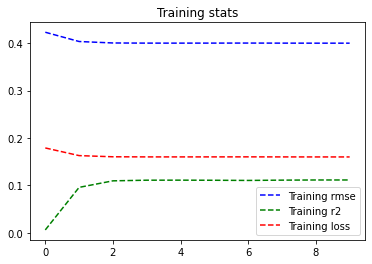

loss : 0.09229039400815964
r_square : -2.421142816543579
root_mean_squared_error : 0.303793340921402


In [67]:
# DNN, all params
model_name = f"dnn_cluster_{cluster}_fullds"
ds_name = "dnn" #["hice00", "hsnw00", "ssh00", "fice00", "airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d", "precip"]

model = DNN_model(datasets[ds_name][0]["Xtrain"].shape[1])
models[model_name] = lauch_train(model, datasets[ds_name][2], datasets[ds_name], epochs=10, batch_size=128, print_arch_model=False, print_history=True)

46/46 [==============================] - 3s 2ms/step


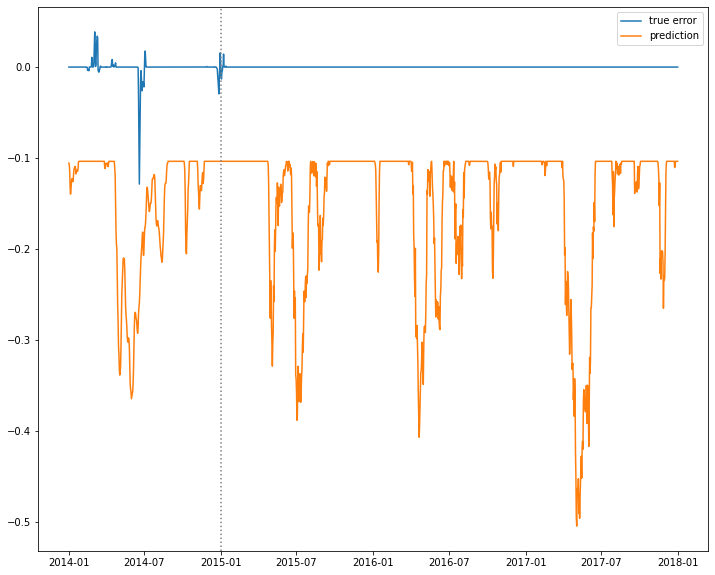

46/46 [==============================] - 0s 805us/step


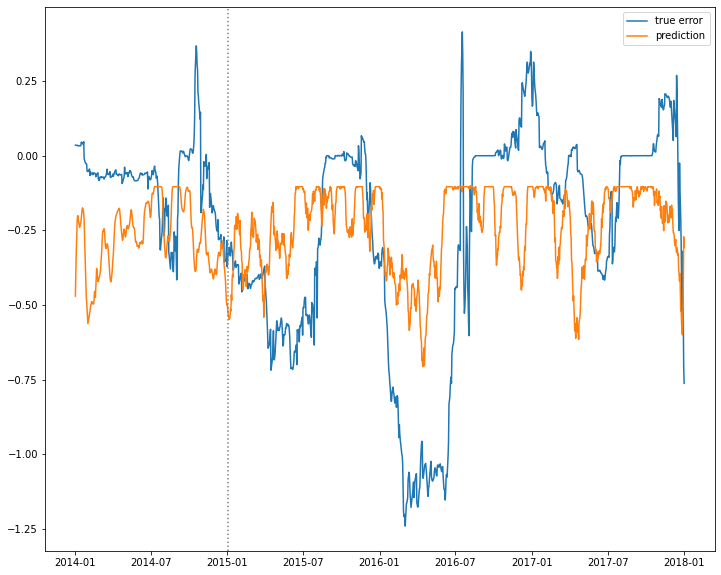

46/46 [==============================] - 0s 806us/step


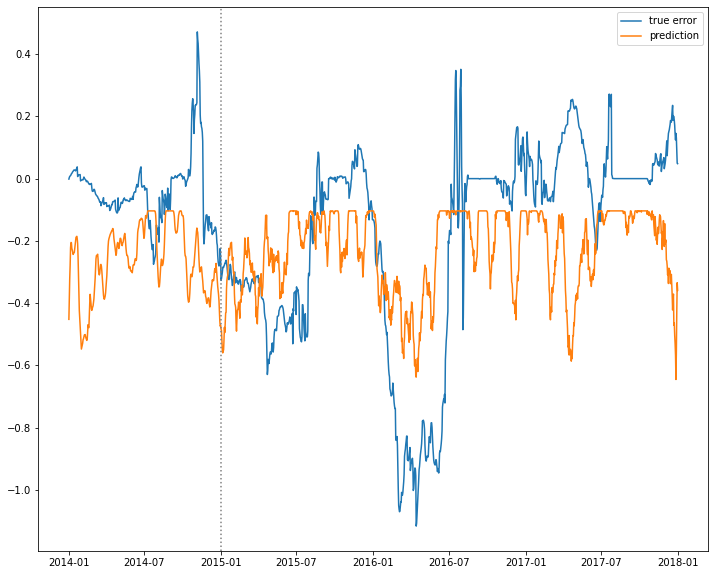

46/46 [==============================] - 0s 808us/step


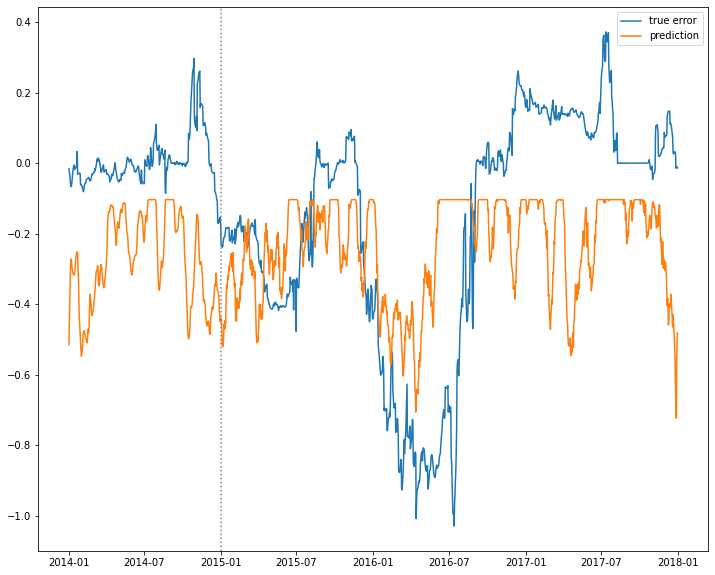

46/46 [==============================] - 0s 808us/step


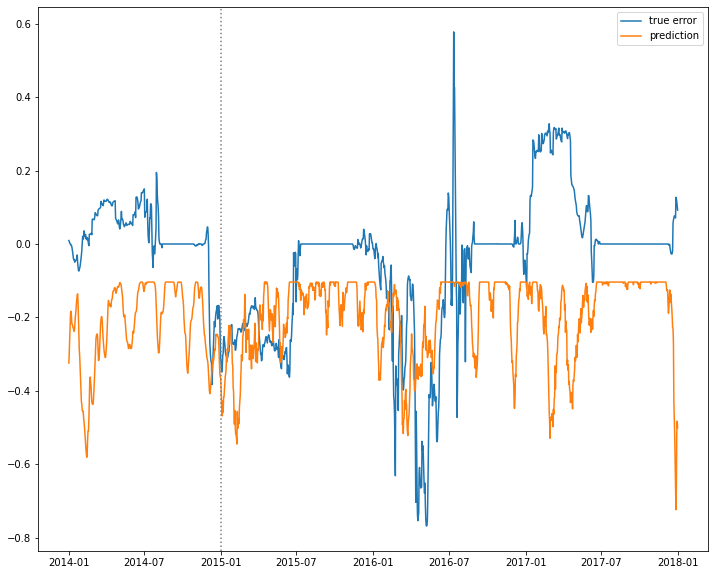

In [68]:
plot_some_pt(models[model_name], datasets[ds_name])

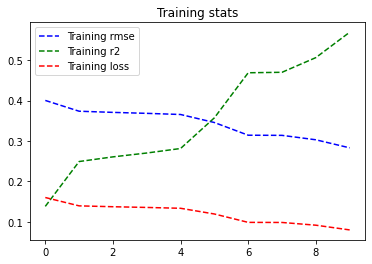

loss : 0.20965713262557983
r_square : -5.712968349456787
root_mean_squared_error : 0.4578833281993866


In [105]:
# LSTM, all params, few epochs
model_name = f"LSTM_cluster_{cluster}_fullds"
ds_name = "lstm" #["hice00", "hsnw00", "ssh00", "fice00", "airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d", "precip"]

model = LSTM_model(datasets[ds_name][0]["Xtrain"].shape[1], datasets[ds_name][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[ds_name][2], datasets[ds_name], epochs=10, batch_size=128, print_arch_model=False, print_history=True)

44/44 [==============================] - 1s 4ms/step


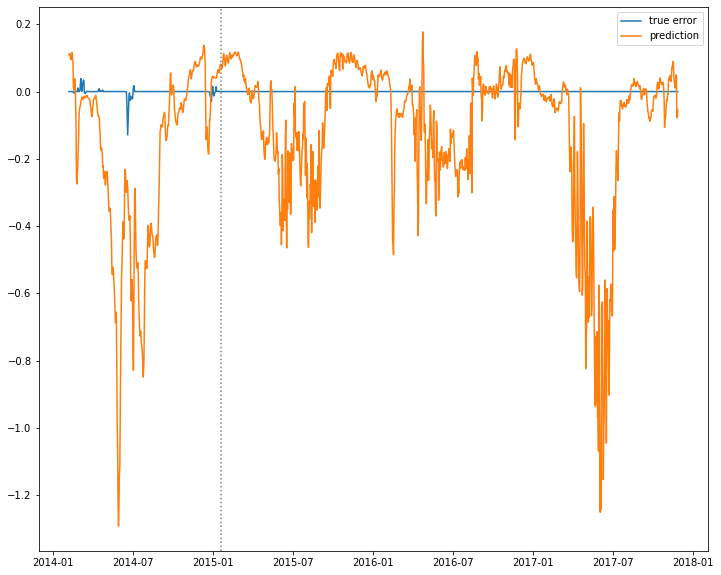

44/44 [==============================] - 0s 4ms/step


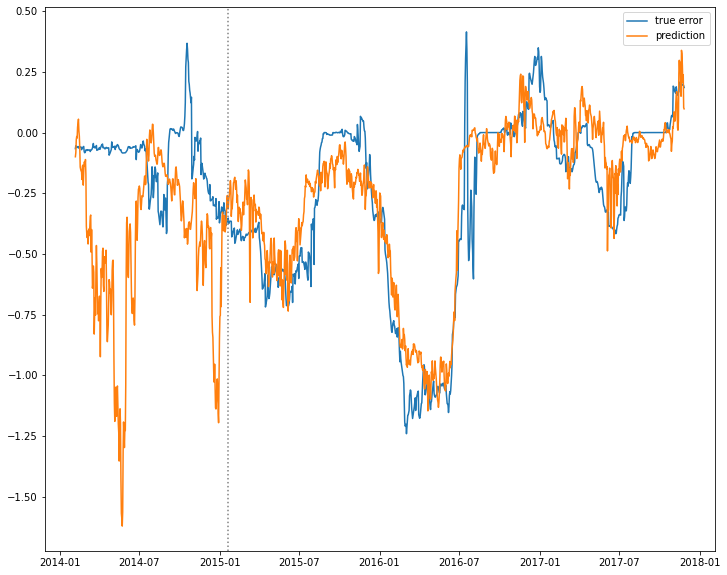

44/44 [==============================] - 0s 3ms/step


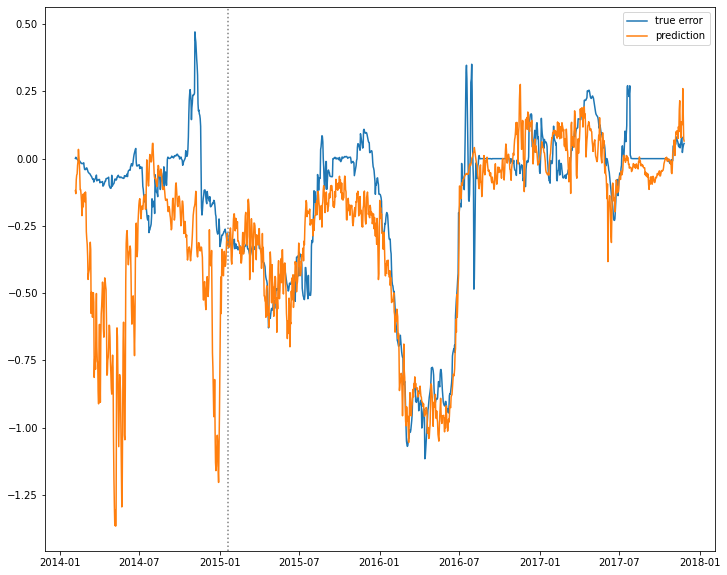

44/44 [==============================] - 0s 3ms/step


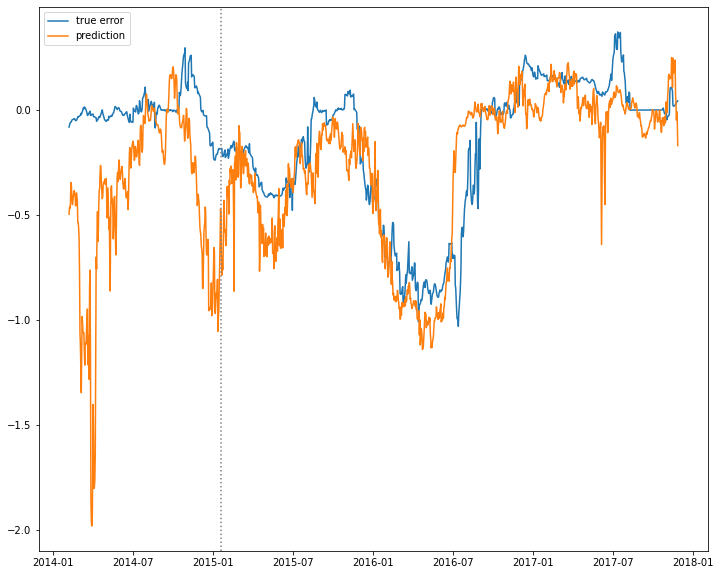

44/44 [==============================] - 0s 3ms/step


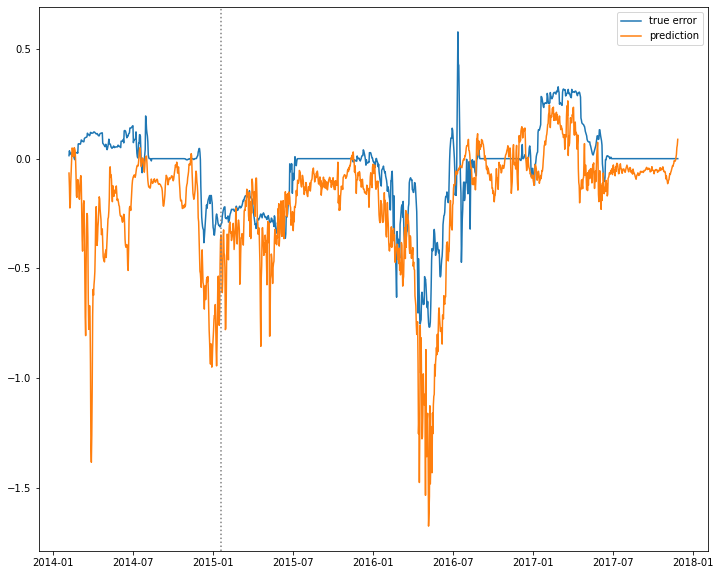

In [107]:
plot_some_pt(models[model_name], datasets[ds_name])

2022-09-02 08:54:42.495361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-02 08:54:42.495406: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-02 08:54:42.495438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-02 08:54:42.495863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
17560/17560 - 294s - loss: 0.1601 - r_square: 0.1397 - root_mean_squared_error: 0.4001 - 294s/epoch - 17ms/step
Epoch 2/50
17560/17560 - 302s - loss: 0.1391 - r_square: 0.2527 - root_mean_squared_error: 0.3729 - 302s/epoch - 17ms/step
Epoch 3/50
17560/17560 - 290s - loss: 0.1376 - r_square: 0.2606 - root_mean_squared_error: 0.3709 - 290s/epoch - 16ms/step
Epoch 4/50
17560/17560 - 316s - loss: 0.1363 - r_square: 0.2676 - root_mean_squared_error: 0.3691 - 316s/epoch - 18ms/step
Epoch 5/50
17560/17560 - 285s - loss: 0.1352 - r_square: 0.2736 - root_mean_squared_error: 0.3676 - 285s/epoch - 16ms/step
Epoch 6/50
17560/17560 - 294s - loss: 0.1321 - r_square: 0.2898 - root_mean_squared_error: 0.3635 - 294s/epoch - 17ms/step
Epoch 7/50
17560/17560 - 303s - loss: 0.1142 - r_square: 0.3865 - root_mean_squared_error: 0.3379 - 303s/epoch - 17ms/step
Epoch 8/50
17560/17560 - 304s - loss: 0.0994 - r_square: 0.4660 - root_mean_squared_error: 0.3152 - 304s/epoch - 17ms/step
Epoch 9/50
17560

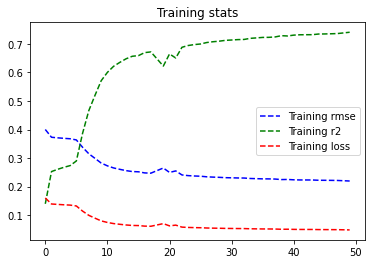

loss : 0.18194936215877533
r_square : -4.825799465179443
root_mean_squared_error : 0.42655521631240845


In [26]:
# LSTM, all params, more epochs
model_name = f"LSTM_cluster_{cluster}_fullds"
ds_name = "lstm" #["hice00", "hsnw00", "ssh00", "fice00", "airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d", "precip"]

model = LSTM_model(datasets[ds_name][0]["Xtrain"].shape[1], datasets[ds_name][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[ds_name][2], datasets[ds_name], epochs=50, batch_size=128, print_arch_model=False, print_history=True, verbose=2)

44/44 [==============================] - 11s 4ms/step


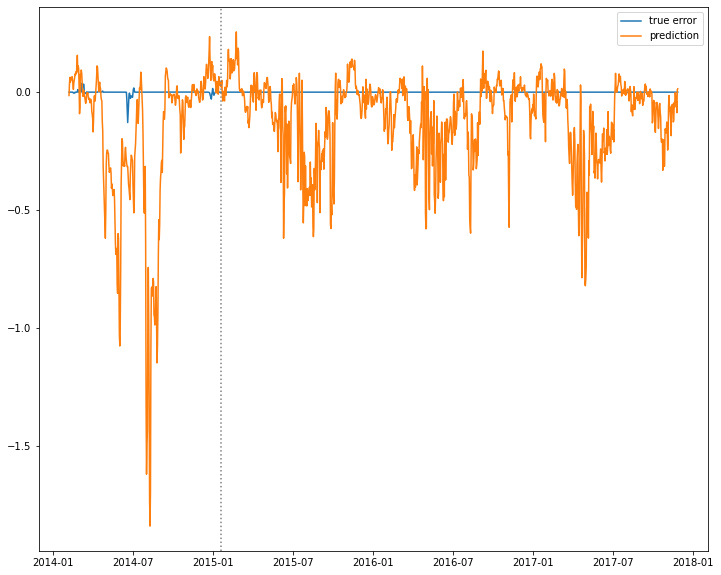

44/44 [==============================] - 0s 4ms/step


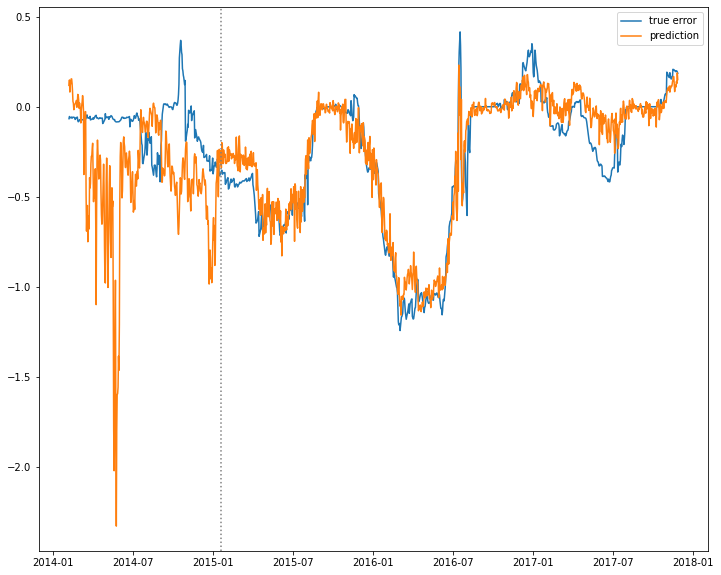

44/44 [==============================] - 0s 3ms/step


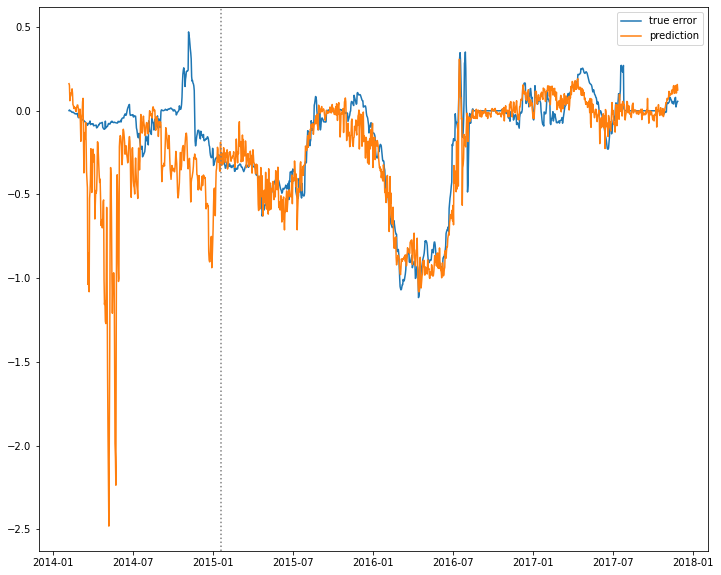

44/44 [==============================] - 0s 3ms/step


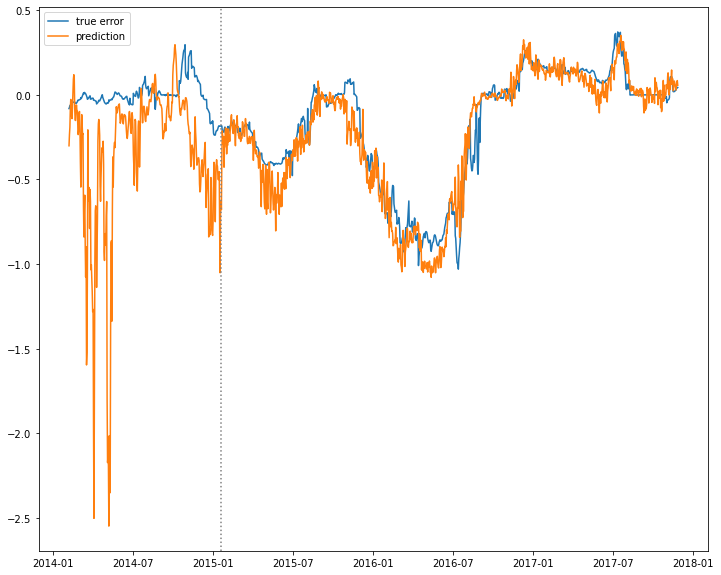

44/44 [==============================] - 0s 3ms/step


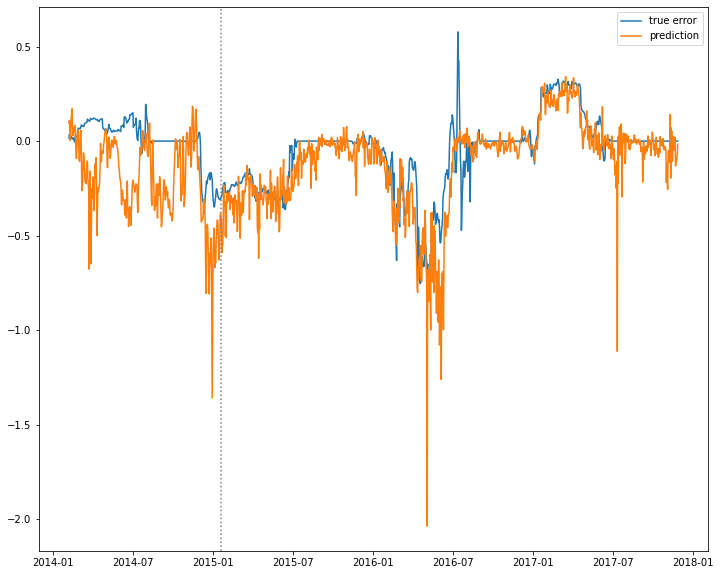

In [27]:
plot_some_pt(models[model_name], datasets[ds_name])

In [32]:
#with open(f'{rootdir}Calliope/models/area_lstm.pickle', "wb") as f:
#    pkl.dump(models[model_name], f, protocol=pkl.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://d9b0837d-bbe5-45b1-85b7-ed7d82b5d690/assets


INFO:tensorflow:Assets written to: ram://d9b0837d-bbe5-45b1-85b7-ed7d82b5d690/assets


2022-09-05 09:01:35.622103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-05 09:01:35.622921: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-05 09:01:35.631393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-05 09:01:35.769075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
17560/17560 - 303s - loss: 0.1608 - r_square: 0.1357 - root_mean_squared_error: 0.4010 - 303s/epoch - 17ms/step
Epoch 2/50
17560/17560 - 292s - loss: 0.1401 - r_square: 0.2473 - root_mean_squared_error: 0.3742 - 292s/epoch - 17ms/step
Epoch 3/50
17560/17560 - 307s - loss: 0.1373 - r_square: 0.2623 - root_mean_squared_error: 0.3705 - 307s/epoch - 17ms/step
Epoch 4/50
17560/17560 - 291s - loss: 0.1354 - r_square: 0.2723 - root_mean_squared_error: 0.3680 - 291s/epoch - 17ms/step
Epoch 5/50
17560/17560 - 301s - loss: 0.1340 - r_square: 0.2797 - root_mean_squared_error: 0.3661 - 301s/epoch - 17ms/step
Epoch 6/50
17560/17560 - 299s - loss: 0.1154 - r_square: 0.3797 - root_mean_squared_error: 0.3397 - 299s/epoch - 17ms/step
Epoch 7/50
17560/17560 - 301s - loss: 0.0970 - r_square: 0.4785 - root_mean_squared_error: 0.3115 - 301s/epoch - 17ms/step
Epoch 8/50
17560/17560 - 292s - loss: 0.0877 - r_square: 0.5288 - root_mean_squared_error: 0.2961 - 292s/epoch - 17ms/step
Epoch 9/50
17560

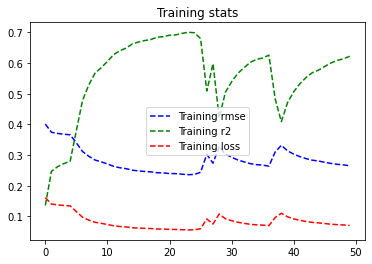

loss : 0.27407708764076233
r_square : -7.775617599487305
root_mean_squared_error : 0.52352374792099


In [27]:
# LSTM, all params except precip
model_name = f"LSTM_cluster_{cluster}"
ds_name = "lstm" #["hice00", "hsnw00", "ssh00", "fice00", "airtmp_mean21d", "mslprs_mean21d", "wndewd_mean21d", "wndnwd_mean21d"]

model = LSTM_model(datasets[ds_name][0]["Xtrain"].shape[1], datasets[ds_name][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[ds_name][2], datasets[ds_name], epochs=50, batch_size=128, print_arch_model=False, print_history=True, verbose=2)

44/44 [==============================] - 2s 4ms/step


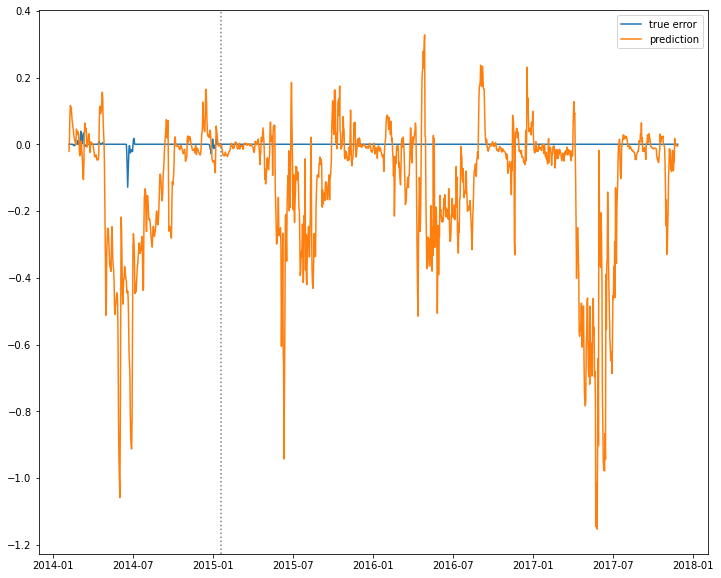

44/44 [==============================] - 0s 3ms/step


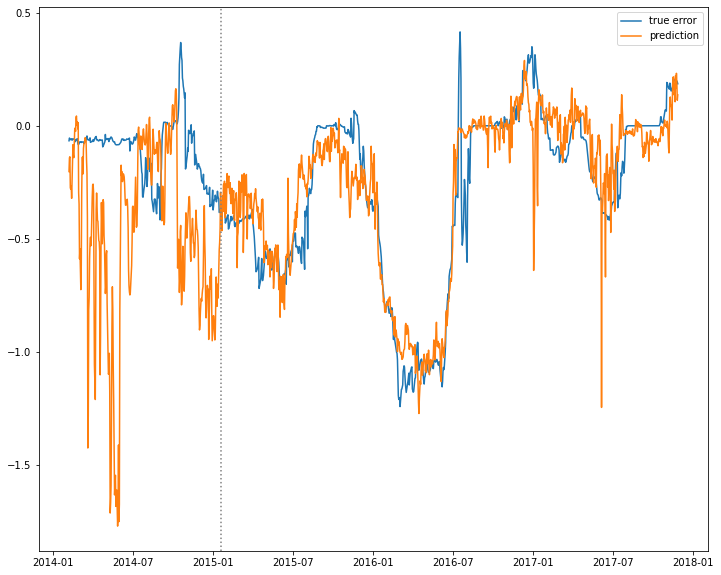

44/44 [==============================] - 0s 3ms/step


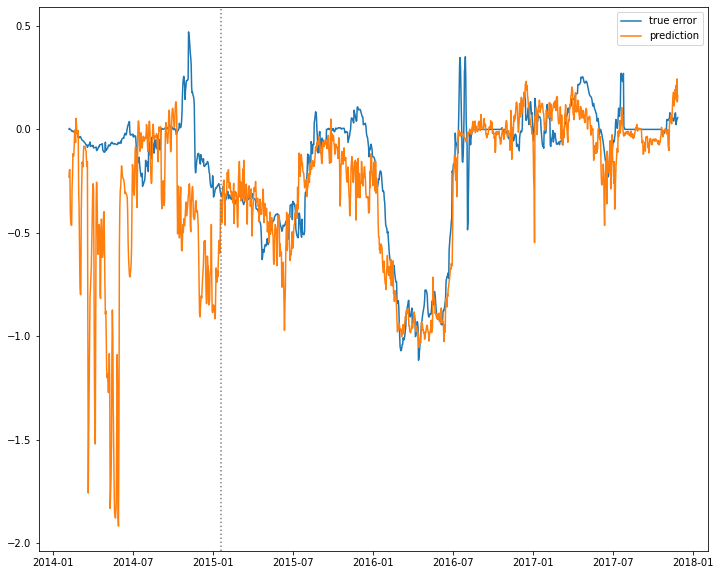

44/44 [==============================] - 0s 3ms/step


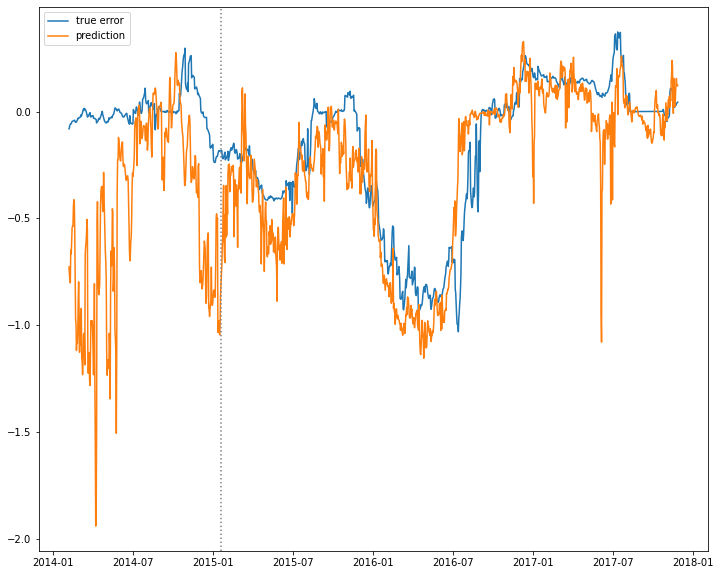

44/44 [==============================] - 0s 3ms/step


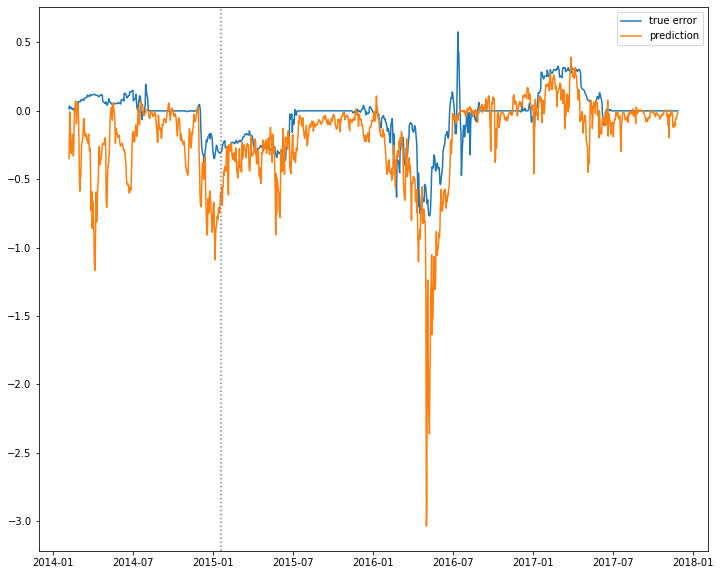

In [28]:
plot_some_pt(models[model_name], datasets[ds_name])

2022-09-06 10:28:41.481393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 10:28:41.499351: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 10:28:41.522259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-06 10:28:41.635287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
17560/17560 - 295s - loss: 0.1620 - r_square: 0.1295 - root_mean_squared_error: 0.4025 - 295s/epoch - 17ms/step
Epoch 2/50
17560/17560 - 305s - loss: 0.1397 - r_square: 0.2491 - root_mean_squared_error: 0.3738 - 305s/epoch - 17ms/step
Epoch 3/50
17560/17560 - 304s - loss: 0.1380 - r_square: 0.2583 - root_mean_squared_error: 0.3715 - 304s/epoch - 17ms/step
Epoch 4/50
17560/17560 - 293s - loss: 0.1369 - r_square: 0.2642 - root_mean_squared_error: 0.3700 - 293s/epoch - 17ms/step
Epoch 5/50
17560/17560 - 300s - loss: 0.1360 - r_square: 0.2693 - root_mean_squared_error: 0.3687 - 300s/epoch - 17ms/step
Epoch 6/50
17560/17560 - 300s - loss: 0.1303 - r_square: 0.2995 - root_mean_squared_error: 0.3610 - 300s/epoch - 17ms/step
Epoch 7/50
17560/17560 - 303s - loss: 0.1088 - r_square: 0.4154 - root_mean_squared_error: 0.3298 - 303s/epoch - 17ms/step
Epoch 8/50
17560/17560 - 295s - loss: 0.0998 - r_square: 0.4634 - root_mean_squared_error: 0.3160 - 295s/epoch - 17ms/step
Epoch 9/50
17560

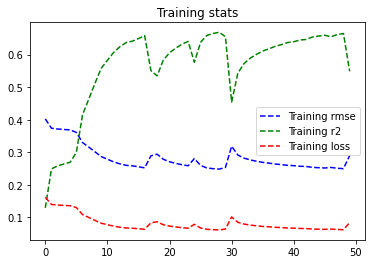

loss : 0.12248225510120392
r_square : -2.921734094619751
root_mean_squared_error : 0.349974662065506


In [24]:
# LSTM, few params
model_name = f"LSTM_cluster_{cluster}_smallds"
ds_name = "lstm" #["hice00", "fice00", "mslprs_mean21d"]
model = LSTM_model(datasets[ds_name][0]["Xtrain"].shape[1], datasets[ds_name][0]["Xtrain"].shape[2])
models[model_name] = lauch_train(model, datasets[ds_name][2], datasets[ds_name], epochs=50, batch_size=128, print_arch_model=False, print_history=True, verbose=2)

44/44 [==============================] - 4s 4ms/step


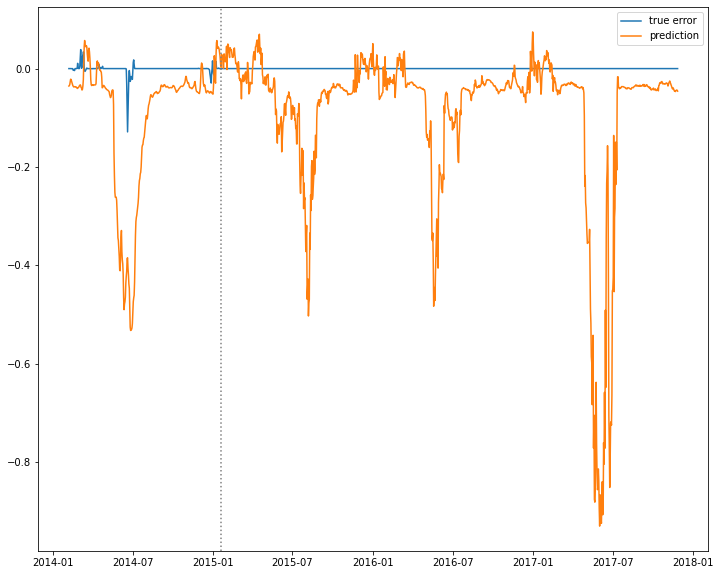

44/44 [==============================] - 0s 4ms/step


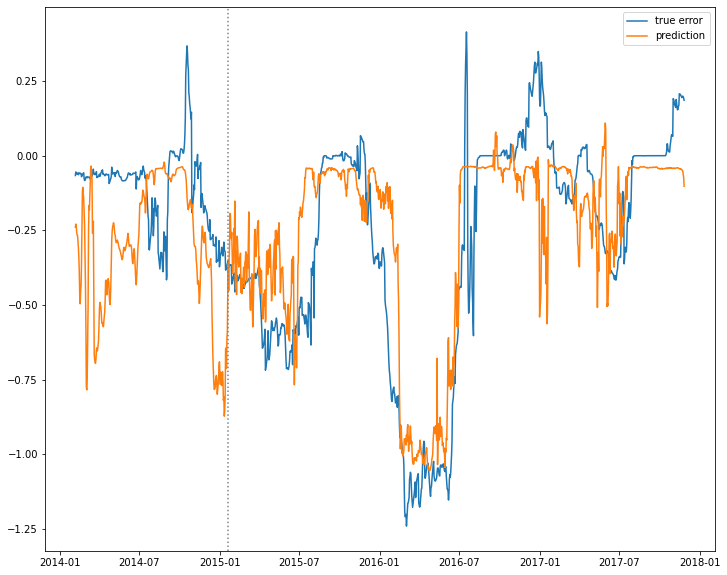

44/44 [==============================] - 0s 5ms/step


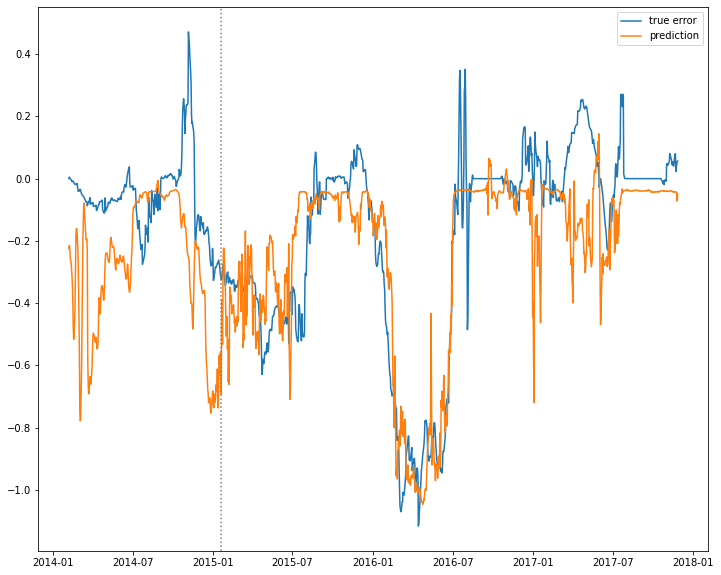

44/44 [==============================] - 0s 6ms/step


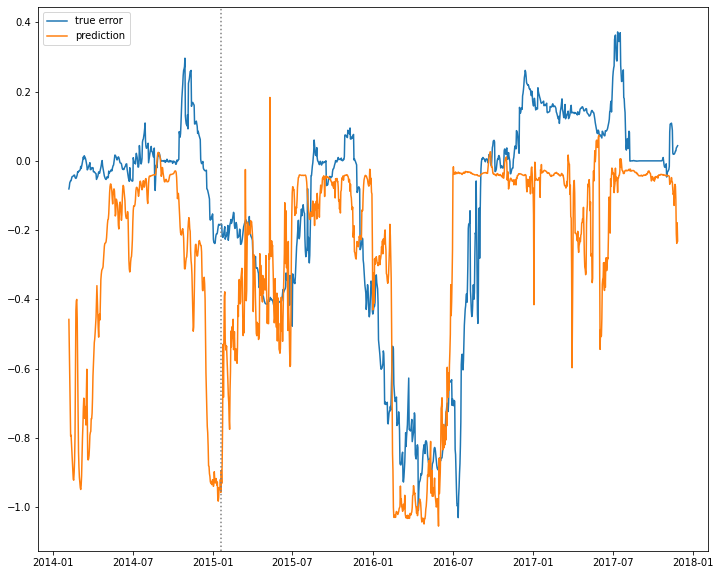

44/44 [==============================] - 0s 5ms/step


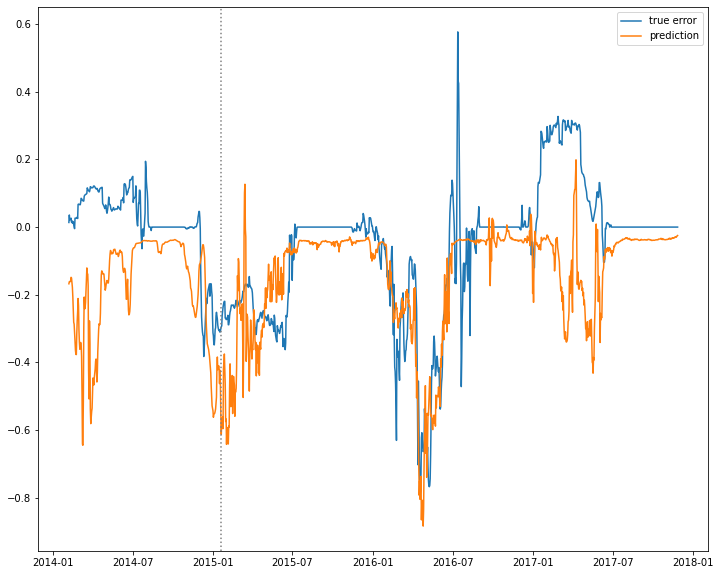

In [25]:
plot_some_pt(models[model_name], datasets[ds_name])

Idea:
- try to adap nn architecture
- for the chosen cluster, observe the correlations with the others data to pick more relevant input feature
- reajust the area by removing the least well predicted points